In [2]:
from pandas import DataFrame, Series, read_csv
import pandas as pd
from dslabs_functions import ts_aggregation_by

file_tag = "covid"
target = "deaths"
index="date"
data: DataFrame = read_csv(
    f"data/{file_tag}/forecast_covid_single.csv",
    index_col="date",
    sep=",",
    decimal=".",
    parse_dates=True,
)
series: Series = data[target]

print("Nr. Records = ", series.shape[0])
print("First timestamp", series.index[0])
print("Last timestamp", series.index[-1])

Nr. Records =  199
First timestamp 2020-01-06 00:00:00
Last timestamp 2023-10-23 00:00:00


# GRANULARITY

### using sum (instead of mean) due to the characteristics of the dataset, ask prof

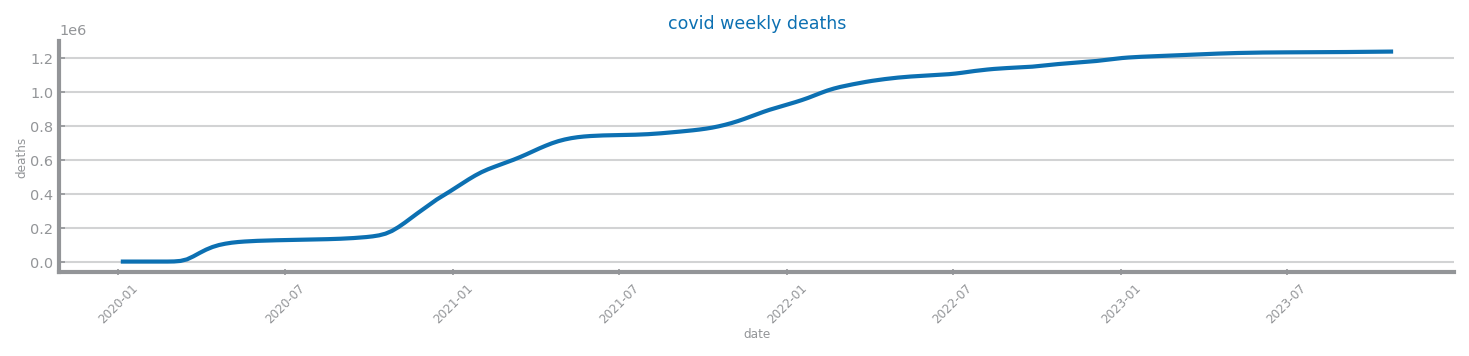

In [3]:
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_line_chart, HEIGHT

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} weekly {target}",
)
show()

### aggregating by month and quarter (original is weekly)

[Timestamp('2020-01-06 00:00:00'), Timestamp('2020-01-13 00:00:00'), Timestamp('2020-01-20 00:00:00'), Timestamp('2020-01-27 00:00:00'), Timestamp('2020-02-03 00:00:00'), Timestamp('2020-02-10 00:00:00'), Timestamp('2020-02-17 00:00:00'), Timestamp('2020-02-24 00:00:00'), Timestamp('2020-03-02 00:00:00'), Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-16 00:00:00'), Timestamp('2020-03-23 00:00:00'), Timestamp('2020-03-30 00:00:00'), Timestamp('2020-04-06 00:00:00'), Timestamp('2020-04-13 00:00:00'), Timestamp('2020-04-20 00:00:00'), Timestamp('2020-04-27 00:00:00'), Timestamp('2020-05-04 00:00:00'), Timestamp('2020-05-11 00:00:00'), Timestamp('2020-05-18 00:00:00'), Timestamp('2020-05-25 00:00:00'), Timestamp('2020-06-01 00:00:00'), Timestamp('2020-06-08 00:00:00'), Timestamp('2020-06-15 00:00:00'), Timestamp('2020-06-22 00:00:00'), Timestamp('2020-06-29 00:00:00'), Timestamp('2020-07-06 00:00:00'), Timestamp('2020-07-13 00:00:00'), Timestamp('2020-07-20 00:00:00'), Timestamp('20

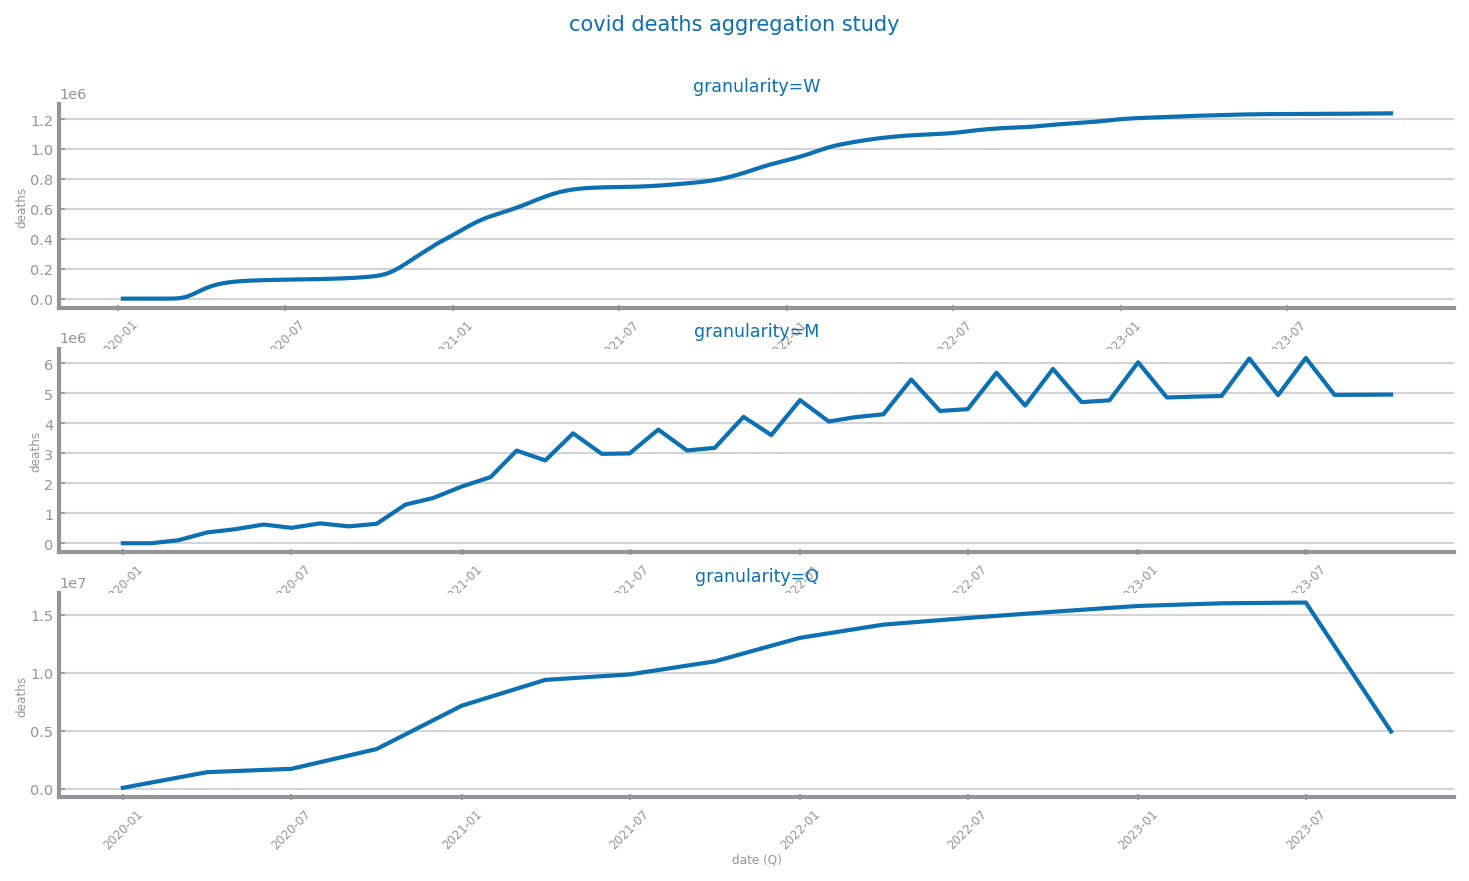

In [4]:
from matplotlib.pyplot import subplots
from matplotlib.axes import Axes
from matplotlib.figure import Figure


grans: list[str] = ["W", "M", "Q"]
fig: Figure
axs: list[Axes]
fig, axs = subplots(len(grans), 1, figsize=(3 * HEIGHT, HEIGHT / 2 * len(grans)))
fig.suptitle(f"{file_tag} {target} aggregation study")

for i in range(len(grans)):
    ss: Series = ts_aggregation_by(series, grans[i], agg_func=sum)
    ss.to_csv(f"data/{file_tag}/aggregation/{grans[i]}.csv")
    print(ss.index.to_list())
    plot_line_chart(
        ss.index.to_list(),
        ss.to_list(),
        ax=axs[i],
        xlabel=f"{ss.index.name} ({grans[i]})",
        ylabel=target,
        title=f"granularity={grans[i]}",
    )
show()

# DISTRIBUTION

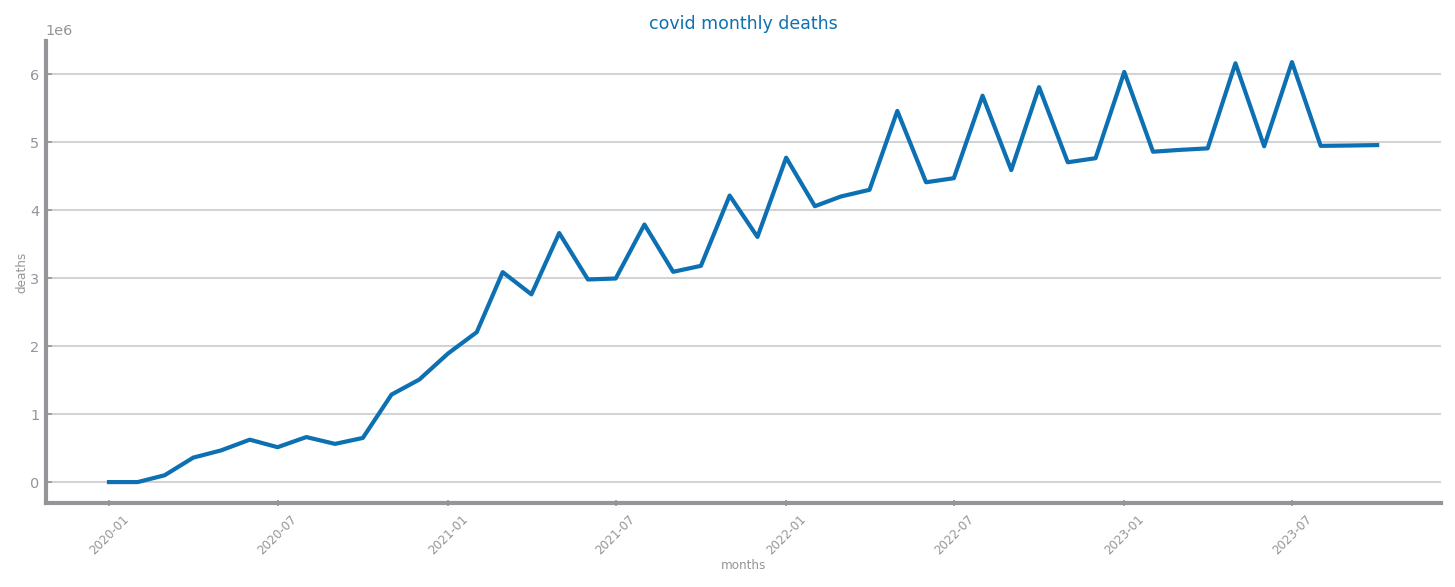

In [5]:
from numpy import sum
from pandas import Series
from matplotlib.pyplot import figure, show
from dslabs_functions import HEIGHT, plot_line_chart, ts_aggregation_by

ss_weeks: Series = ts_aggregation_by(series, gran_level="W", agg_func=sum)
ss_months: Series = ts_aggregation_by(series, gran_level="M", agg_func=sum)
ss_quarters: Series = ts_aggregation_by(series, gran_level="Q", agg_func=sum)

figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    ss_months.index.to_list(),
    ss_months.to_list(),
    xlabel="months",
    ylabel=target,
    title=f"{file_tag} monthly {target}",
)
show()

### BOXPLOTS

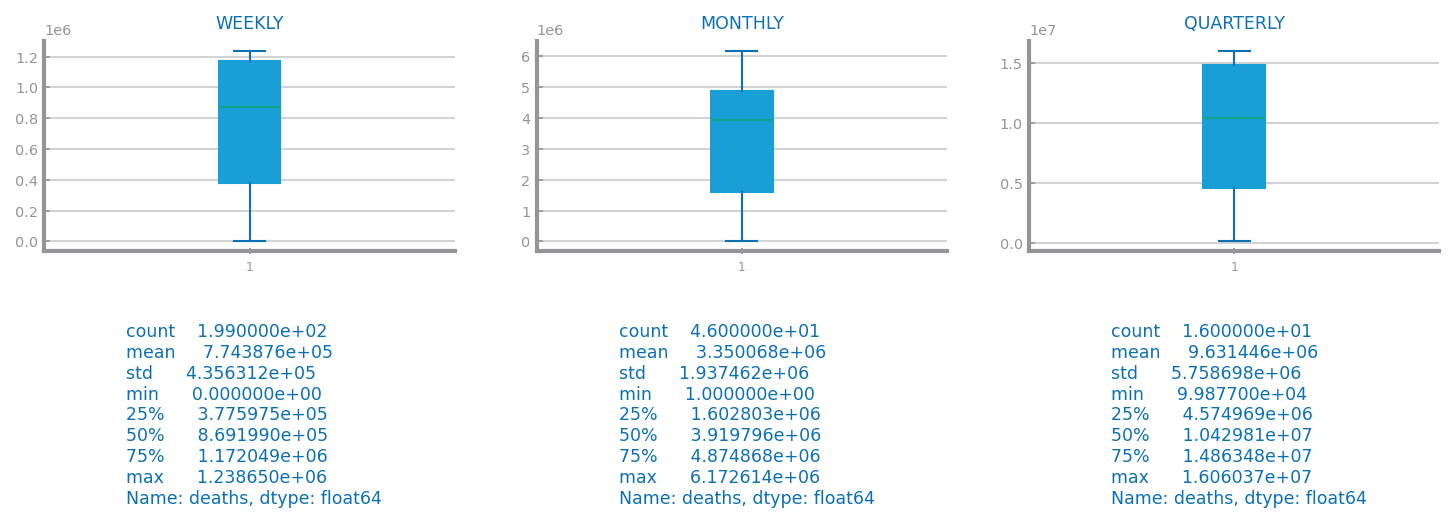

In [6]:
from numpy import array
from matplotlib.pyplot import show, subplots
from matplotlib.figure import Figure
from dslabs_functions import set_chart_labels

fig: Figure
axs: array
fig, axs = subplots(2, 3, figsize=(3 * HEIGHT, HEIGHT))
set_chart_labels(axs[0, 0], title="WEEKLY")
axs[0, 0].boxplot(series)
set_chart_labels(axs[0, 1], title="MONTHLY")
axs[0, 1].boxplot(ss_months)
set_chart_labels(axs[0, 2], title="QUARTERLY")
axs[0, 2].boxplot(ss_quarters)

axs[1, 0].grid(False)
axs[1, 0].set_axis_off()
axs[1, 0].text(0.2, 0, str(series.describe()), fontsize="small")

axs[1, 1].grid(False)
axs[1, 1].set_axis_off()
axs[1, 1].text(0.2, 0, str(ss_months.describe()), fontsize="small")

axs[1, 2].grid(False)
axs[1, 2].set_axis_off()
axs[1, 2].text(0.2, 0, str(ss_quarters.describe()), fontsize="small")
show()

### HISTOGRAMS

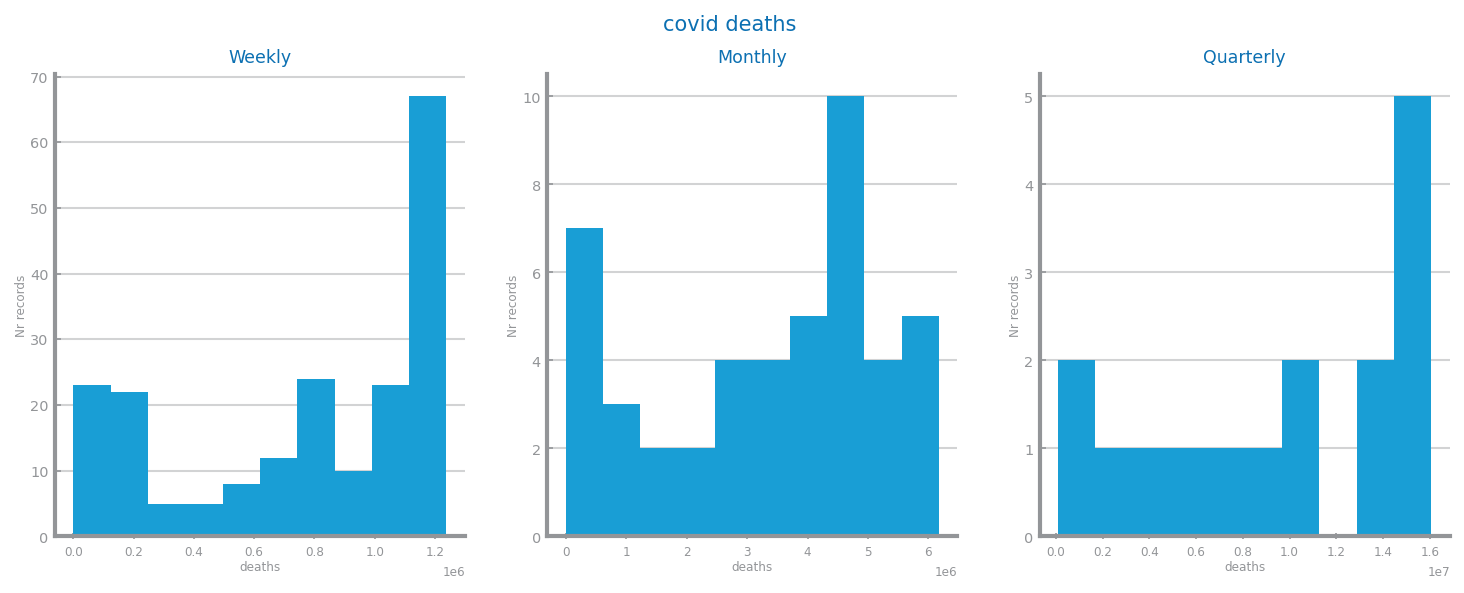

In [7]:
grans: list[Series] = [ss_weeks, ss_months, ss_quarters]
gran_names: list[str] = ["Weekly", "Monthly", "Quarterly"]
fig: Figure
axs: array
fig, axs = subplots(1, len(grans), figsize=(len(grans) * HEIGHT, HEIGHT))
fig.suptitle(f"{file_tag} {target}")
for i in range(len(grans)):
    set_chart_labels(axs[i], title=f"{gran_names[i]}", xlabel=target, ylabel="Nr records")
    axs[i].hist(grans[i].values)
show()

### LAG-PLOTS

<Axes: xlabel='date', ylabel='deaths'>

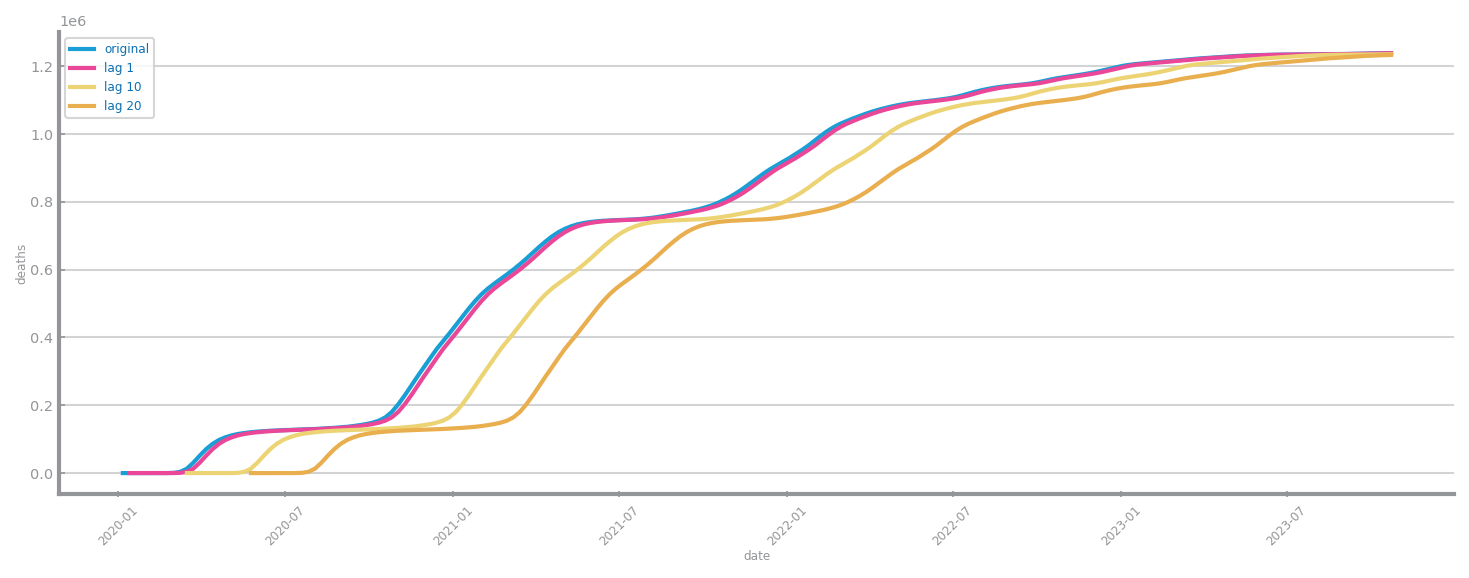

In [8]:
from dslabs_functions import plot_multiline_chart


def get_lagged_series(series: Series, max_lag: int, delta: int = 1):
    lagged_series: dict = {"original": series, "lag 1": series.shift(1)}
    for i in range(delta, max_lag + 1, delta):
        lagged_series[f"lag {i}"] = series.shift(i)
    return lagged_series


figure(figsize=(3 * HEIGHT, HEIGHT))
lags = get_lagged_series(series, 20, 10)
plot_multiline_chart(series.index.to_list(), lags, xlabel=index, ylabel=target)

### CORRELOGRAM

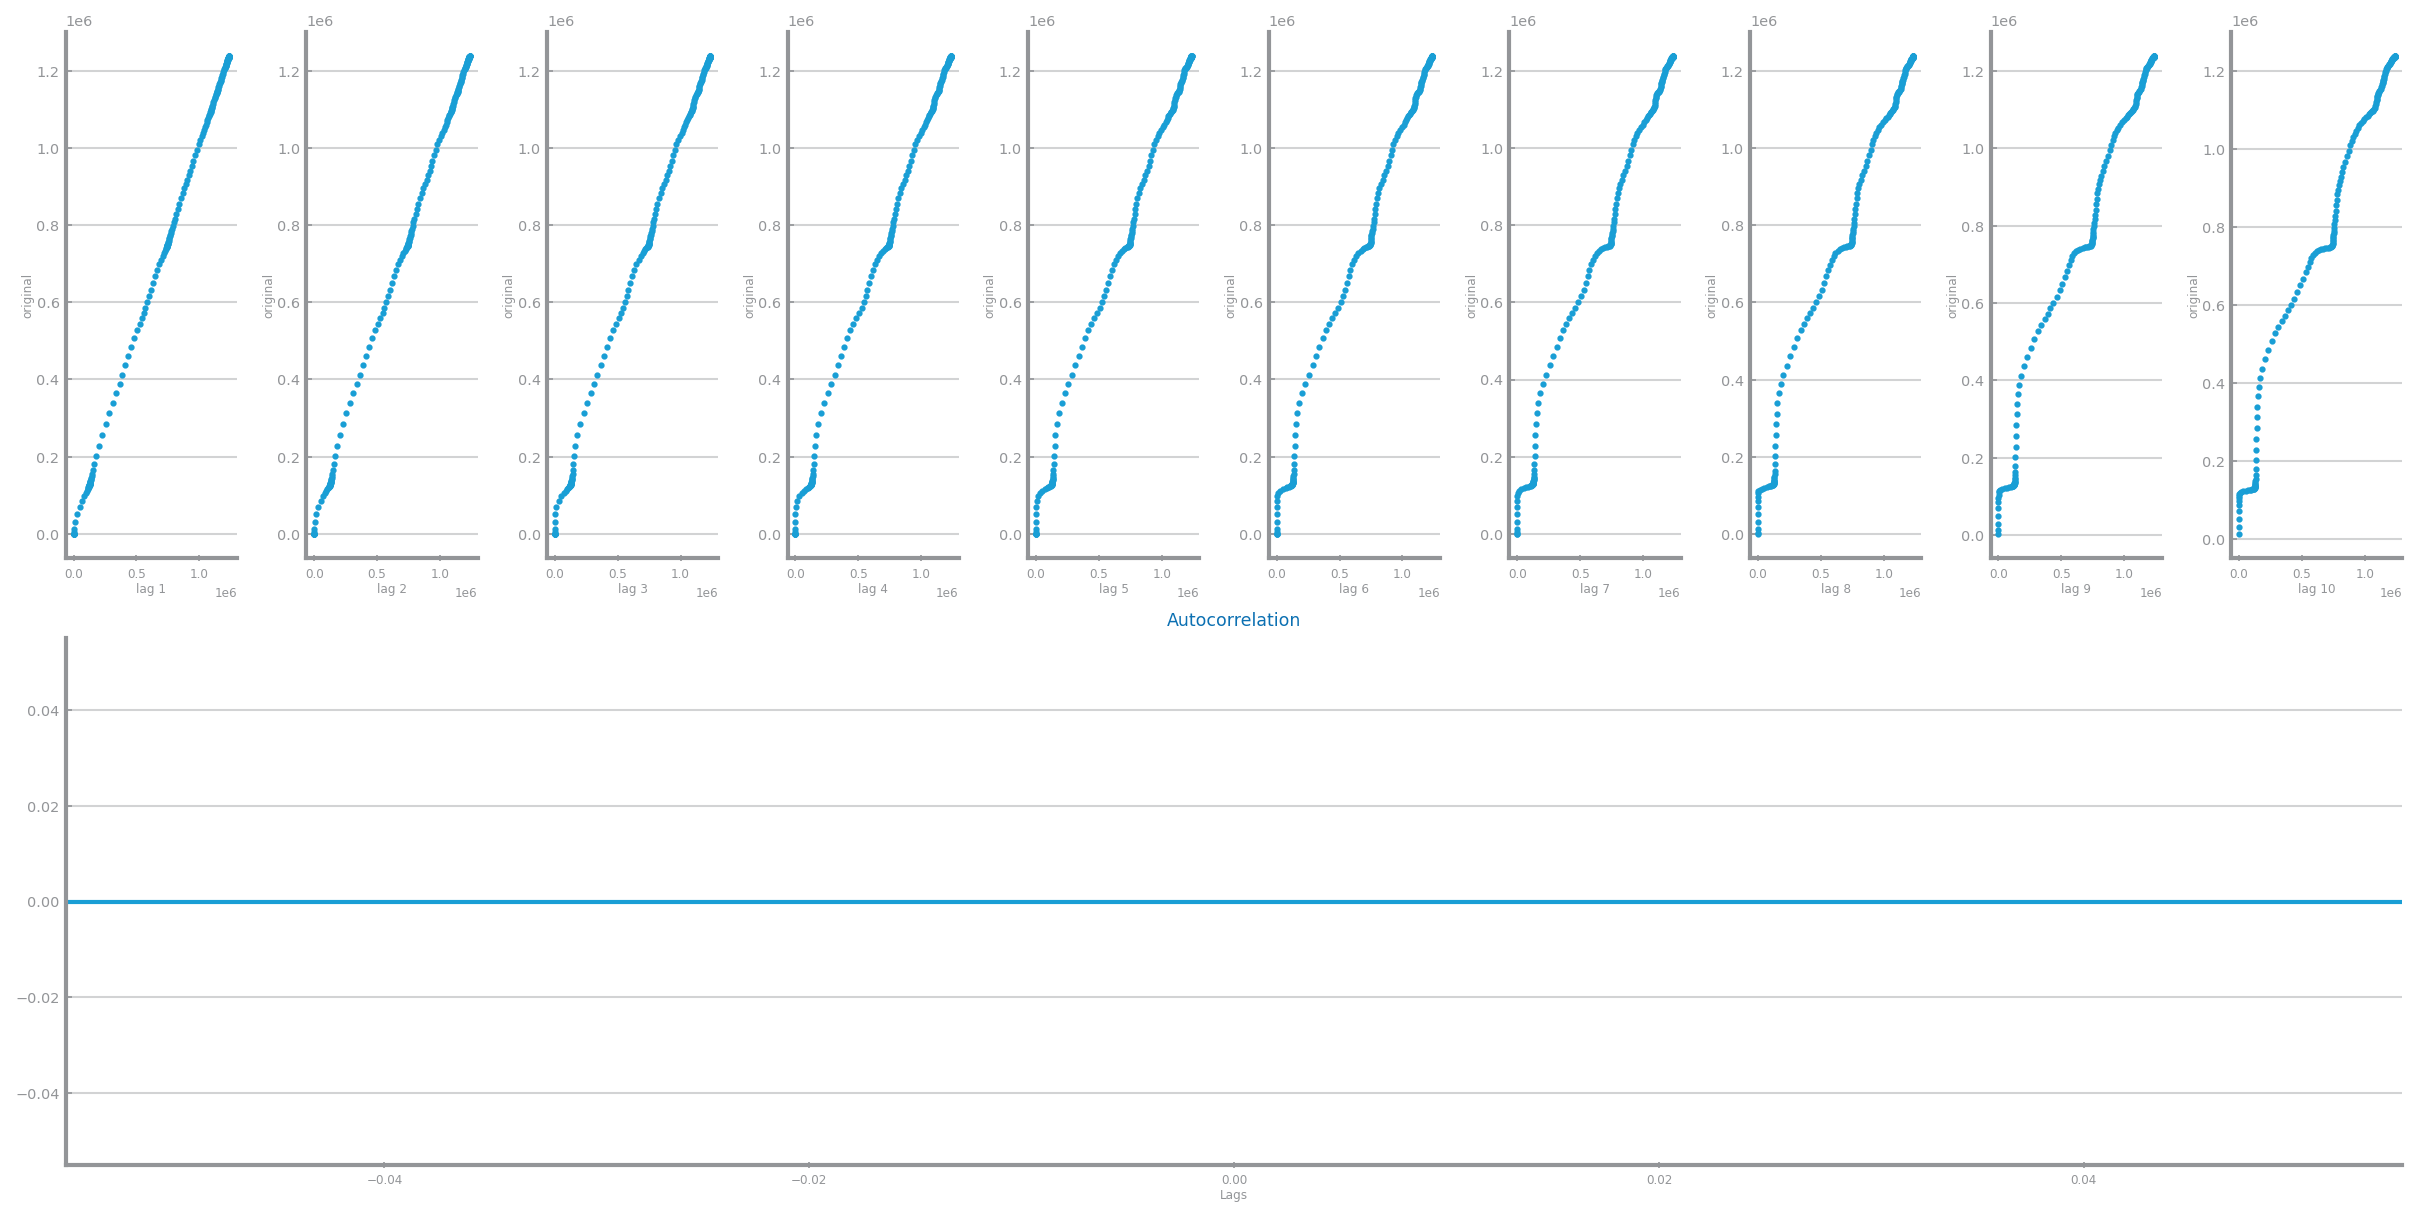

In [9]:
from matplotlib.pyplot import setp
from matplotlib.gridspec import GridSpec


def autocorrelation_study(series: Series, max_lag: int, delta: int = 1):
    k: int = int(max_lag / delta)
    fig = figure(figsize=(4 * HEIGHT, 2 * HEIGHT), constrained_layout=True)
    gs = GridSpec(2, k, figure=fig)

    series_values: list = series.tolist()
    for i in range(1, k + 1):
        ax = fig.add_subplot(gs[0, i - 1])
        lag = i * delta
        ax.scatter(series.shift(lag).tolist(), series_values)
        ax.set_xlabel(f"lag {lag}")
        ax.set_ylabel("original")
    ax = fig.add_subplot(gs[1, :])
    ax.acorr(series, maxlags=max_lag)
    ax.set_title("Autocorrelation")
    ax.set_xlabel("Lags")
    return


autocorrelation_study(series, 10, 1)

# STATIONARITY

### COMPONENT STUDY

In [10]:
from pandas import Series
from matplotlib.pyplot import subplots, show, gca
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose
from dslabs_functions import HEIGHT, set_chart_labels


def plot_components(
    series: Series,
    title: str = "",
    x_label: str = "time",
    y_label: str = "",
) -> list[Axes]:
    decomposition: DecomposeResult = seasonal_decompose(series, model="add")
    components: dict = {
        "observed": series,
        "trend": decomposition.trend,
        "seasonal": decomposition.seasonal,
        "residual": decomposition.resid,
    }
    rows: int = len(components)
    fig: Figure
    axs: list[Axes]
    fig, axs = subplots(rows, 1, figsize=(3 * HEIGHT, rows * HEIGHT))
    fig.suptitle(f"{title}")
    i: int = 0
    for key in components:
        set_chart_labels(axs[i], title=key, xlabel=x_label, ylabel=y_label)
        axs[i].plot(components[key])
        i += 1
    return axs

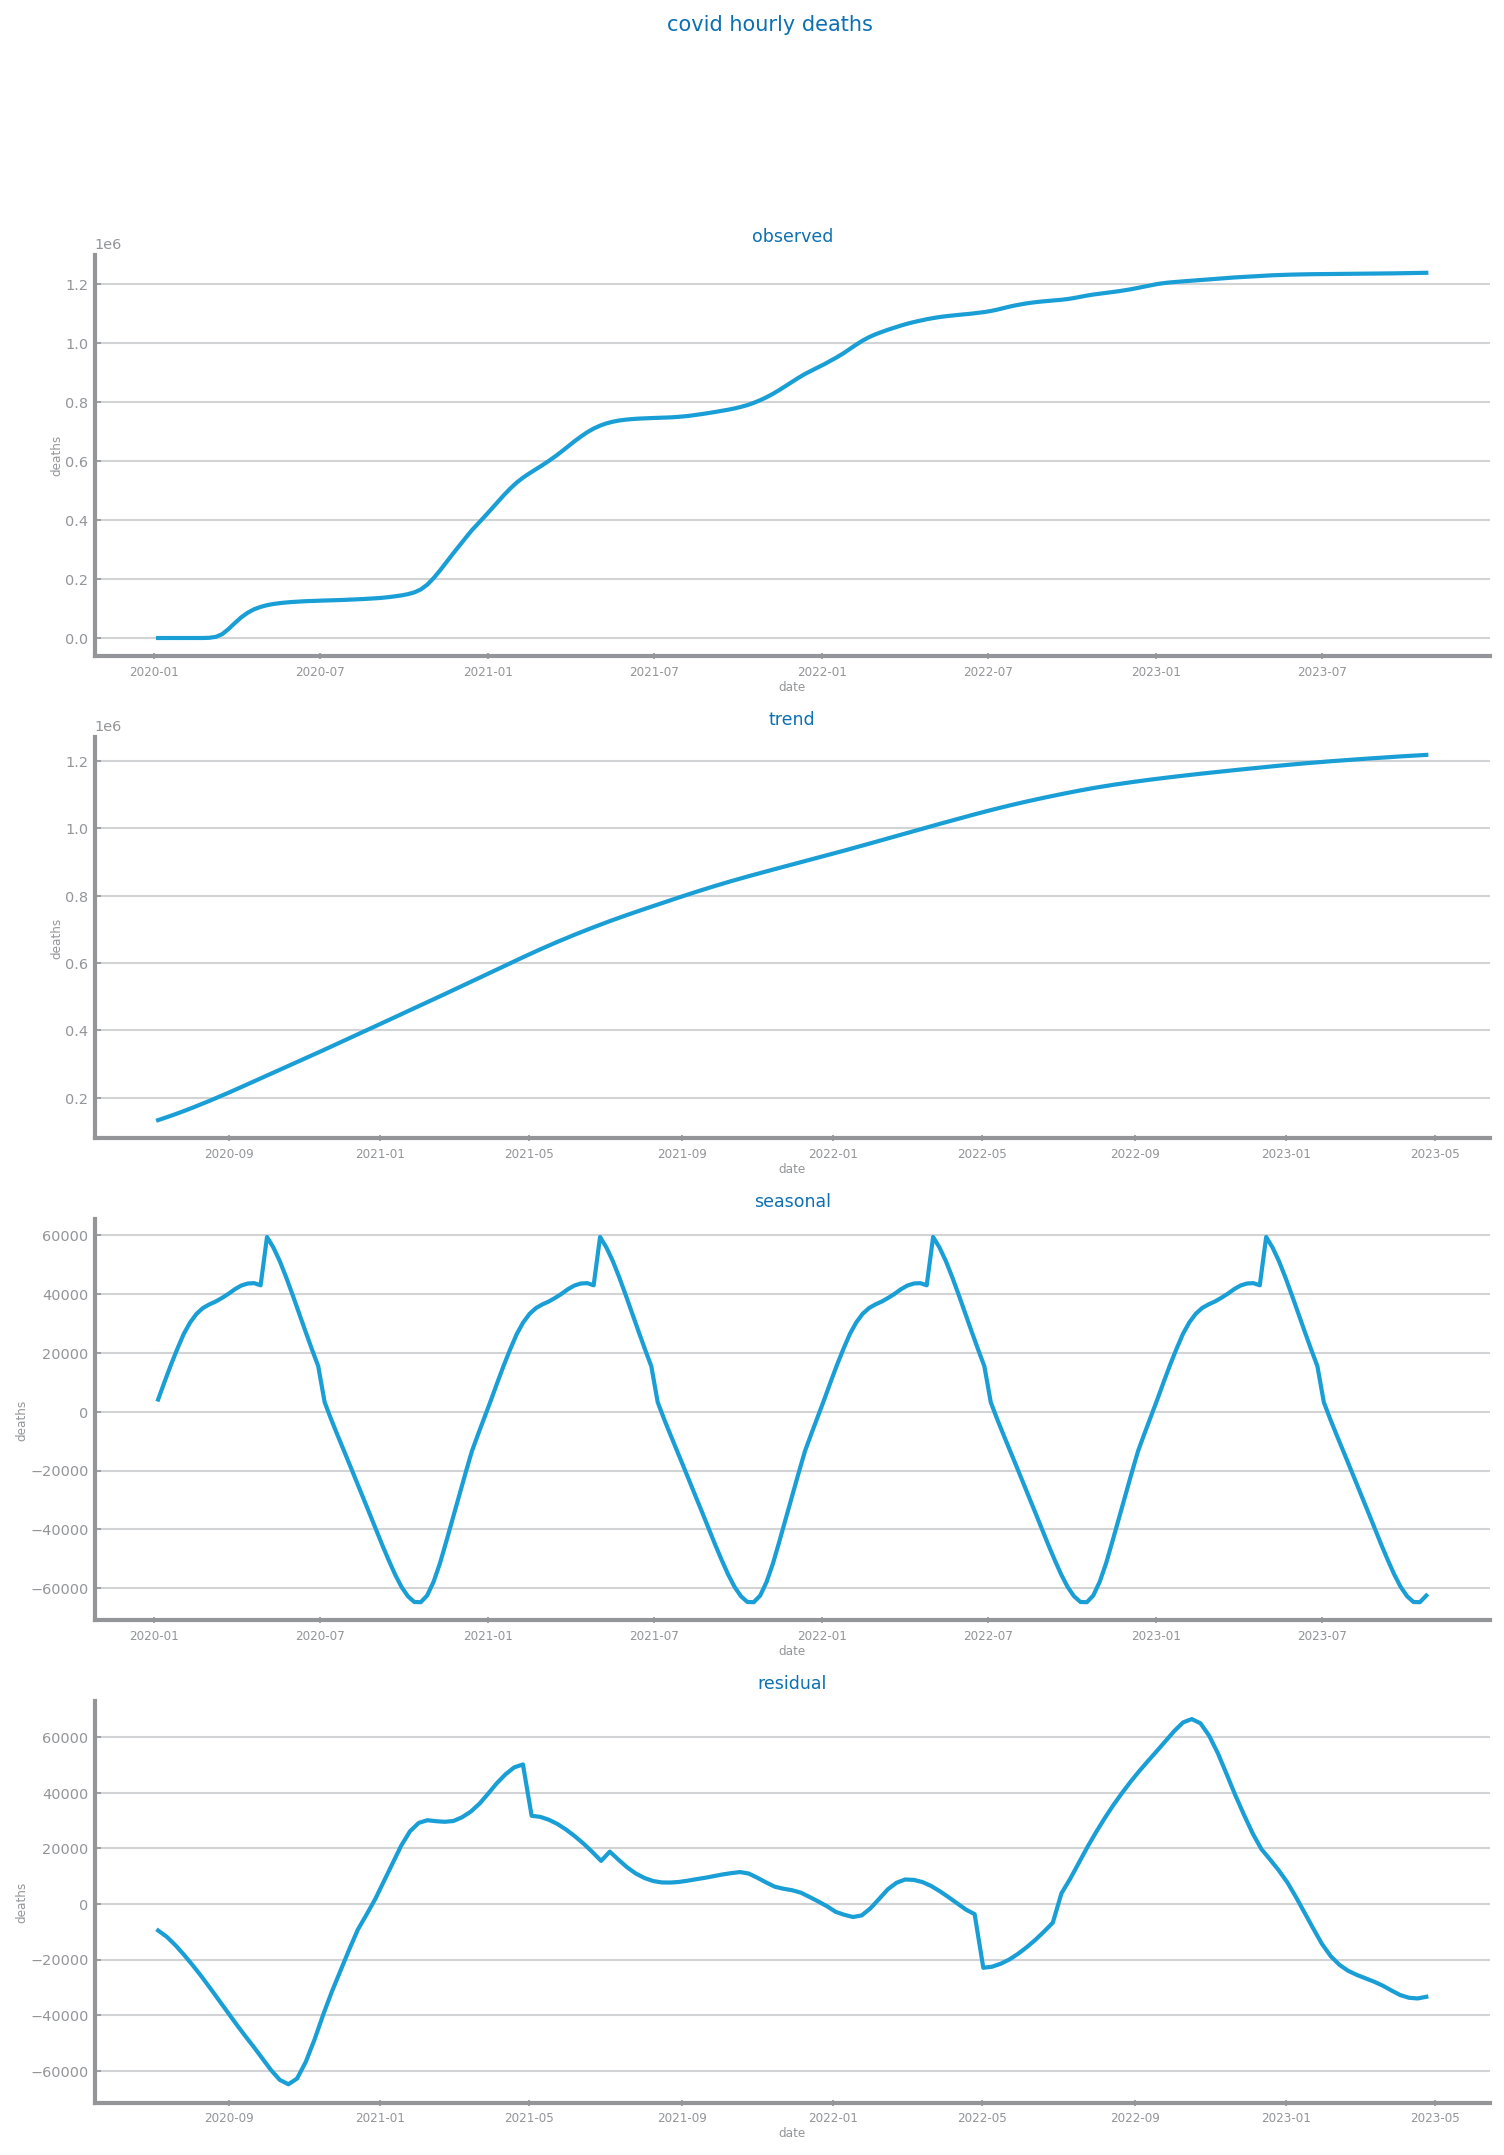

In [11]:
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_line_chart

plot_components(
    series,
    title=f"{file_tag} hourly {target}",
    x_label=series.index.name,
    y_label=target,
)
show()

### STATIONARY STUDY

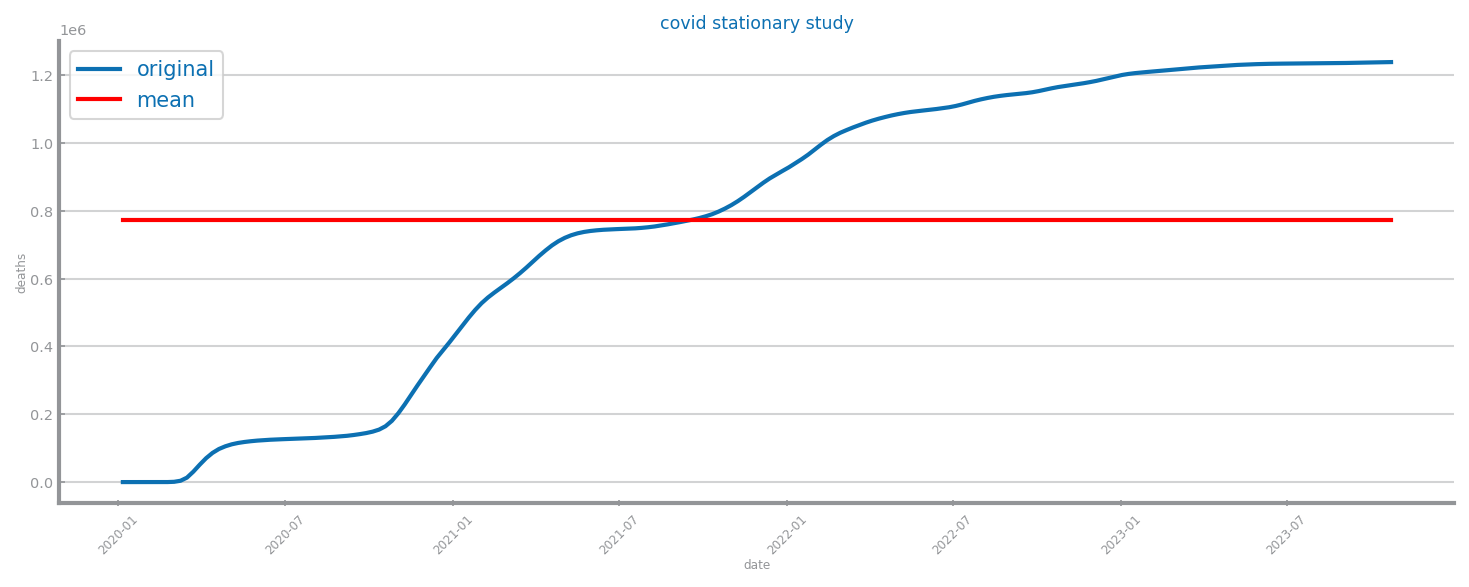

In [12]:
from matplotlib.pyplot import plot, legend

figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} stationary study",
    name="original",
)
n: int = len(series)
plot(series.index, [series.mean()] * n, "r-", label="mean")
legend()
show()

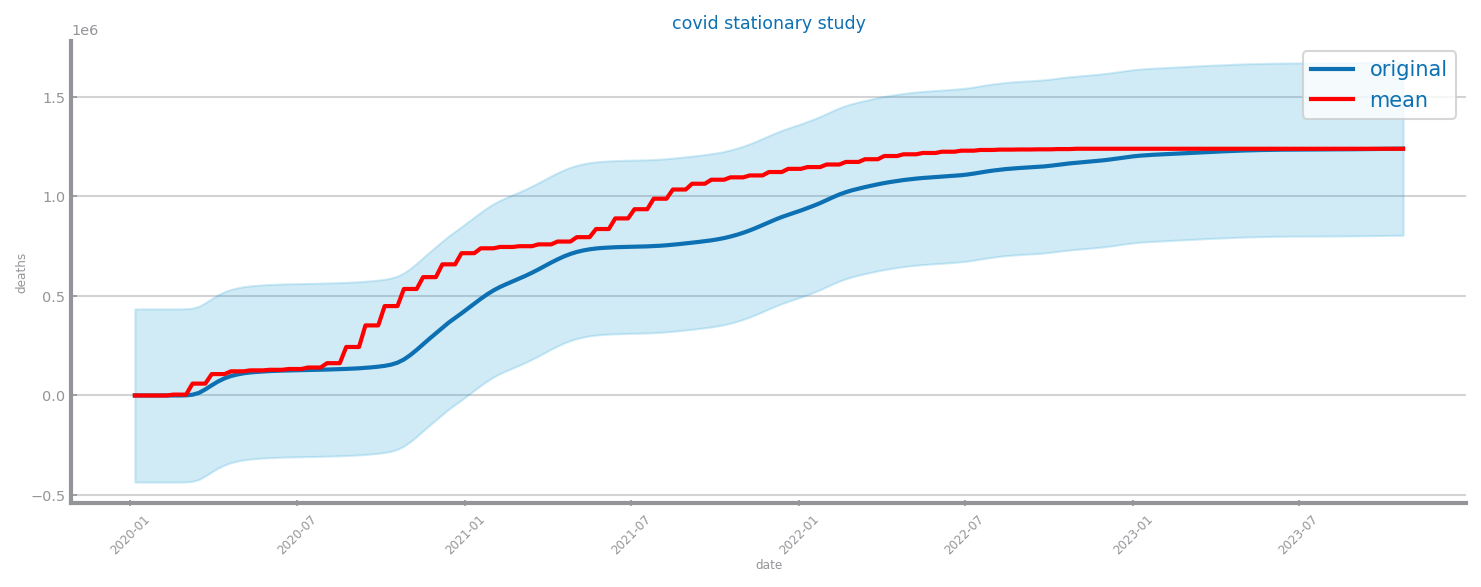

In [13]:
BINS = 50
mean_line: list[float] = []

for i in range(BINS):
    segment: Series = series[i * n // BINS : (i + 1) * n // BINS]
    mean_value: list[float] = [segment.mean()] * (n // BINS)
    mean_line += mean_value
mean_line += [mean_line[-1]] * (n - len(mean_line))

figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} stationary study",
    name="original",
    show_stdev=True,
)
n: int = len(series)
plot(series.index, mean_line, "r-", label="mean")
legend()
show()

### AUGMENTED DICKEY-FULLER TEST

In [14]:
from statsmodels.tsa.stattools import adfuller


def eval_stationarity(series: Series) -> bool:
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.3f}")
    print(f"p-value: {result[1]:.3f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.3f}")
    return result[1] <= 0.05


print(f"The series {('is' if eval_stationarity(series) else 'is not')} stationary")

ADF Statistic: -2.156
p-value: 0.223
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575
The series is not stationary


# EVALUATION (LINEAR REGRESSION)

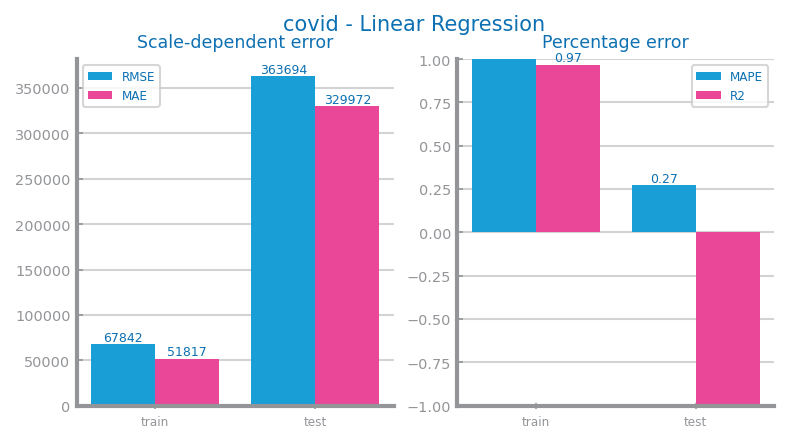

In [15]:
from numpy import arange
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import savefig
from sklearn.linear_model import LinearRegression
from dslabs_functions import series_train_test_split, plot_forecasting_eval

filename: str = "data/covid/forecast_covid_single.csv"
file_tag: str = "covid"
target: str = "deaths"
timecol: str = "date"

data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
series: Series = data[target]
train, test = series_train_test_split(data, trn_pct=0.67)

trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(data)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression")
savefig(f"images/{file_tag}/linear_regression_eval.png")

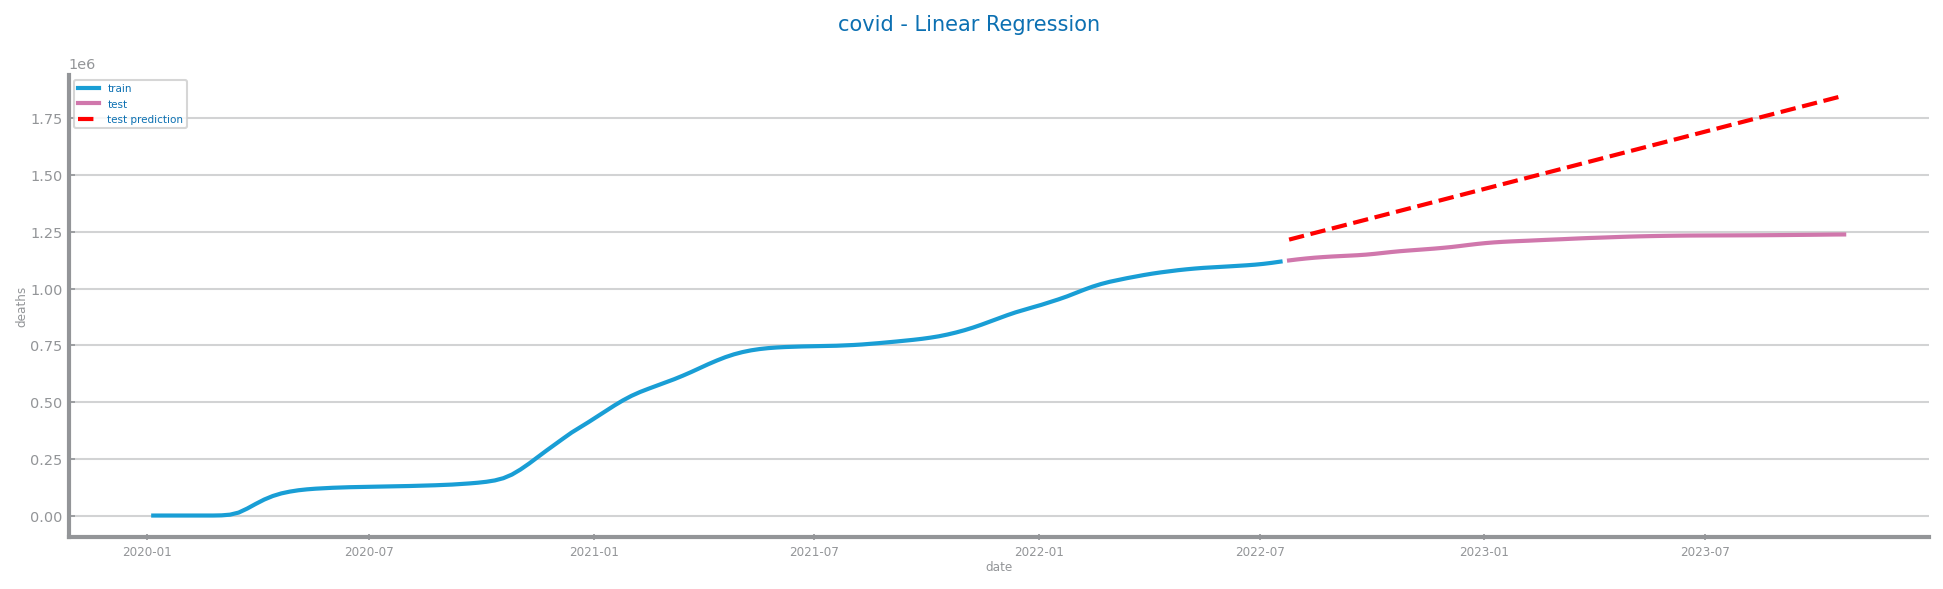

In [16]:
from dslabs_functions import plot_forecasting_series

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}/linear_regression_forecast.png")

# AGGREGATION

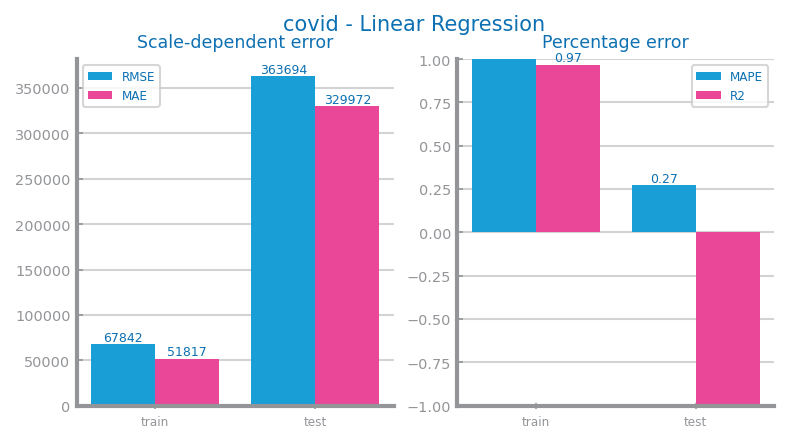

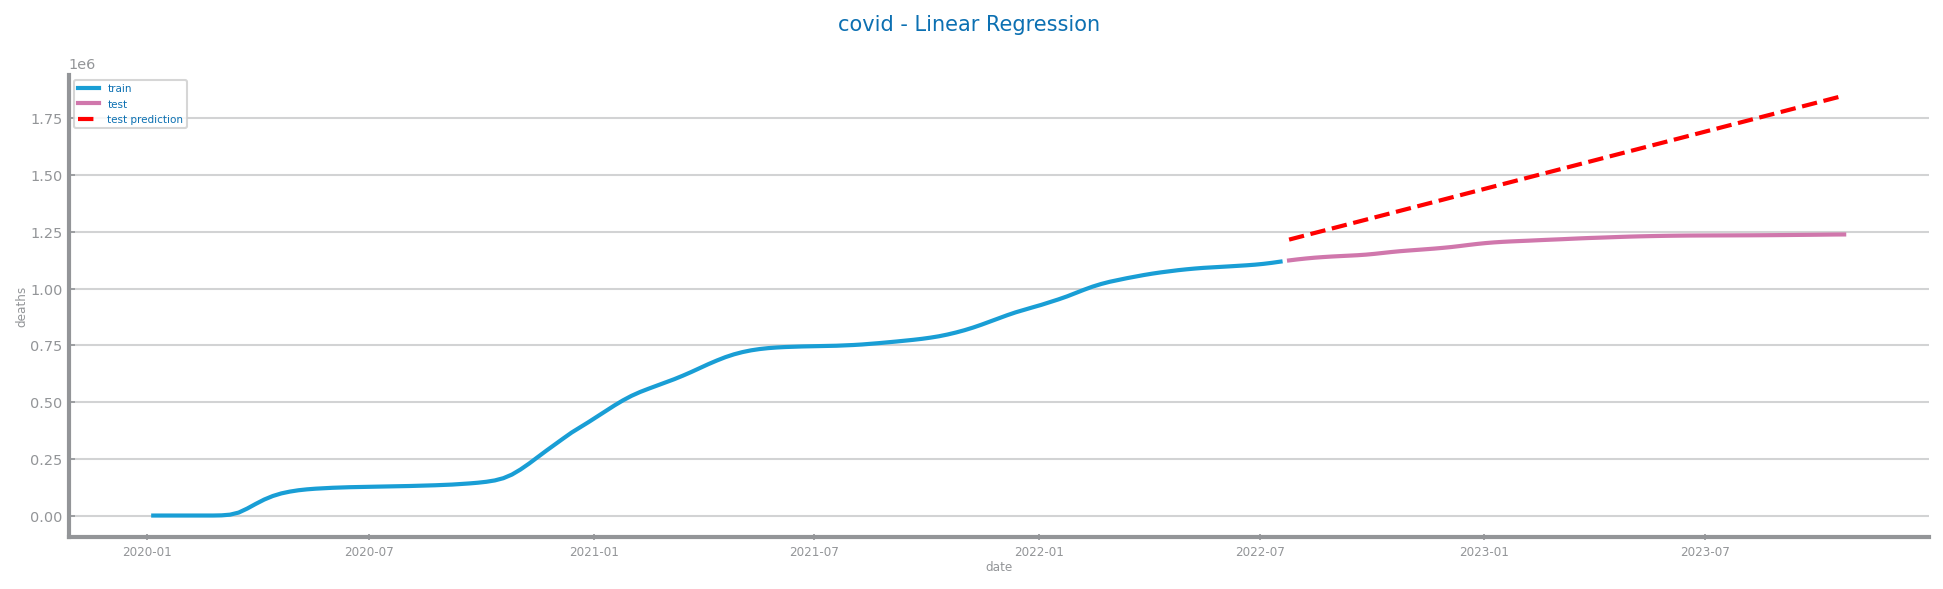

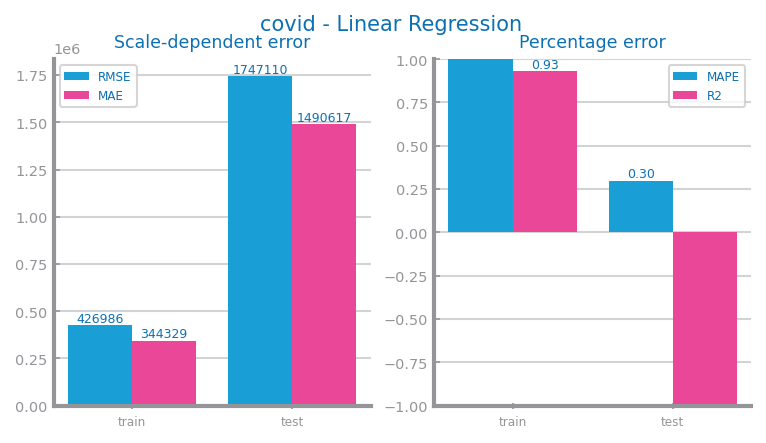

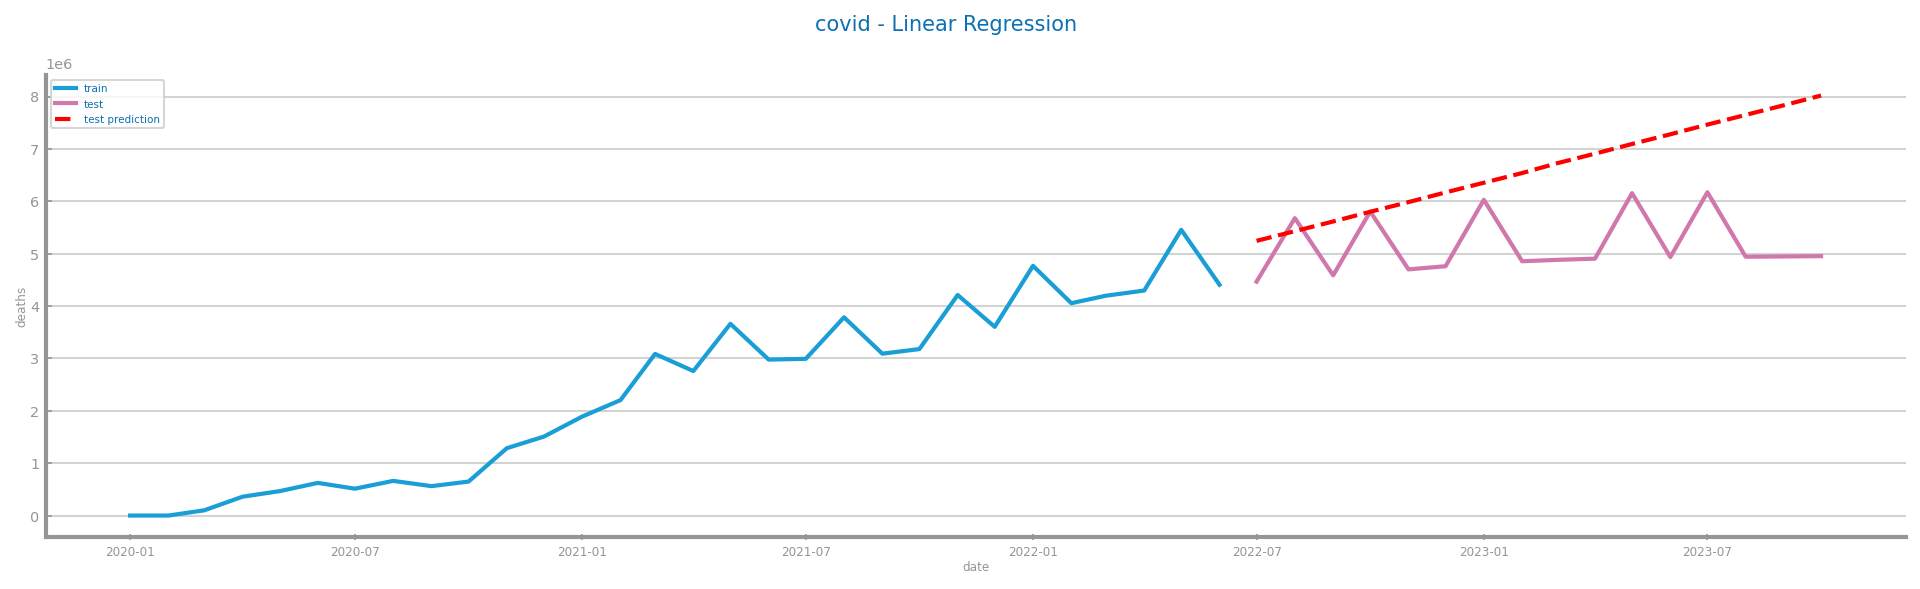

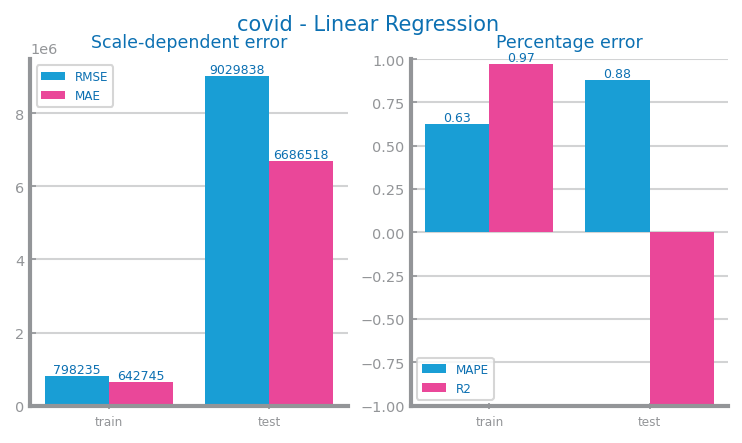

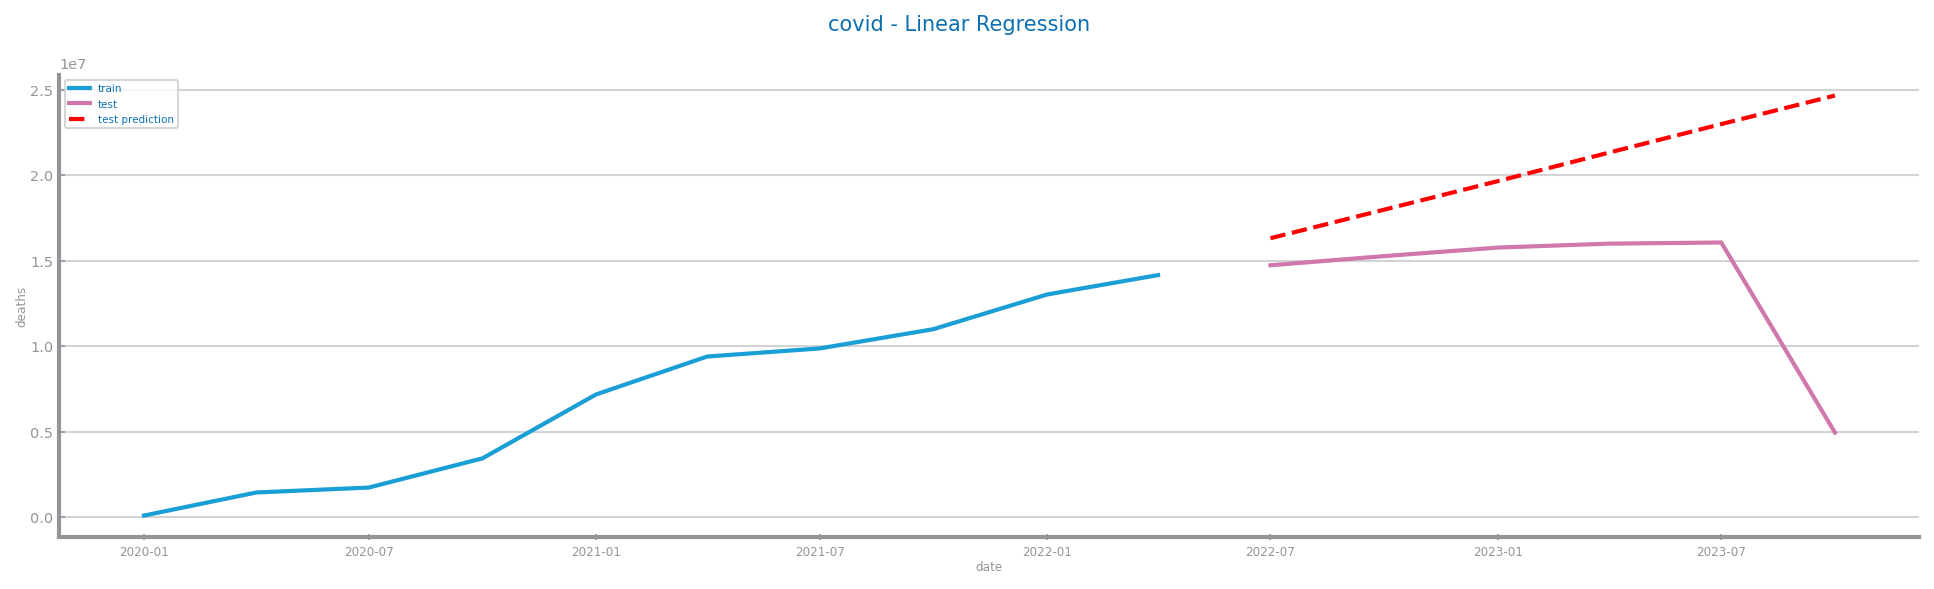

In [17]:
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_line_chart, ts_aggregation_by, HEIGHT

gran_letters = ["W", "M", "Q"]

for i in range(len(gran_letters)):
    ss_data: DataFrame = read_csv(f"data/{file_tag}/aggregation/{gran_letters[i]}.csv", index_col=timecol, sep=",", decimal=".", parse_dates=True)
    train, test = series_train_test_split(ss_data, trn_pct=0.67)

    trnX = arange(len(train)).reshape(-1, 1)
    trnY = train.to_numpy()
    tstX = arange(len(train), len(ss_data)).reshape(-1, 1)
    tstY = test.to_numpy()

    model = LinearRegression()
    model.fit(trnX, trnY)

    prd_trn: Series = Series(model.predict(trnX), index=train.index)
    prd_tst: Series = Series(model.predict(tstX), index=test.index)

    plot_forecasting_eval(
        train, 
        test, 
        prd_trn, 
        prd_tst, 
        title=f"{file_tag} - Linear Regression"
    )
    savefig(f"images/{file_tag}/aggregation/{gran_letters[i]}_linear_regression_eval.png")

    plot_forecasting_series(
        train,
        test,
        prd_tst,
        title=f"{file_tag} - Linear Regression",
        xlabel=timecol,
        ylabel=target,
    )
    savefig(f"images/{file_tag}/aggregation/{gran_letters[i]}_linear_regression_forecast.png")
show()

# SMOOTHING (should we use sum or mean?)

date
2020-01-06   NaN
2020-01-13   NaN
2020-01-20   NaN
2020-01-27   NaN
2020-02-03   NaN
Name: deaths, dtype: float64


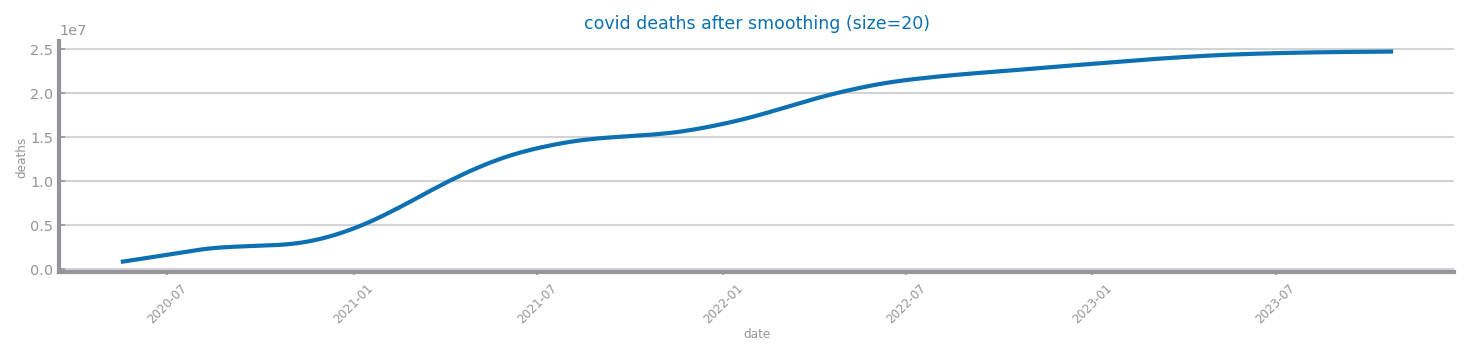

In [18]:
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_line_chart, HEIGHT

filename: str = f"data/{file_tag}/aggregation/W.csv"
data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
series: Series = data[target]

WIN_SIZE = 20
ss_smooth: Series = series.rolling(window=WIN_SIZE).sum()

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    ss_smooth.index.to_list(),
    ss_smooth.to_list(),
    xlabel=ss_smooth.index.name,
    ylabel=target,
    title=f"{file_tag} {target} after smoothing (size={WIN_SIZE})",
)
print(ss_smooth.head())
show()

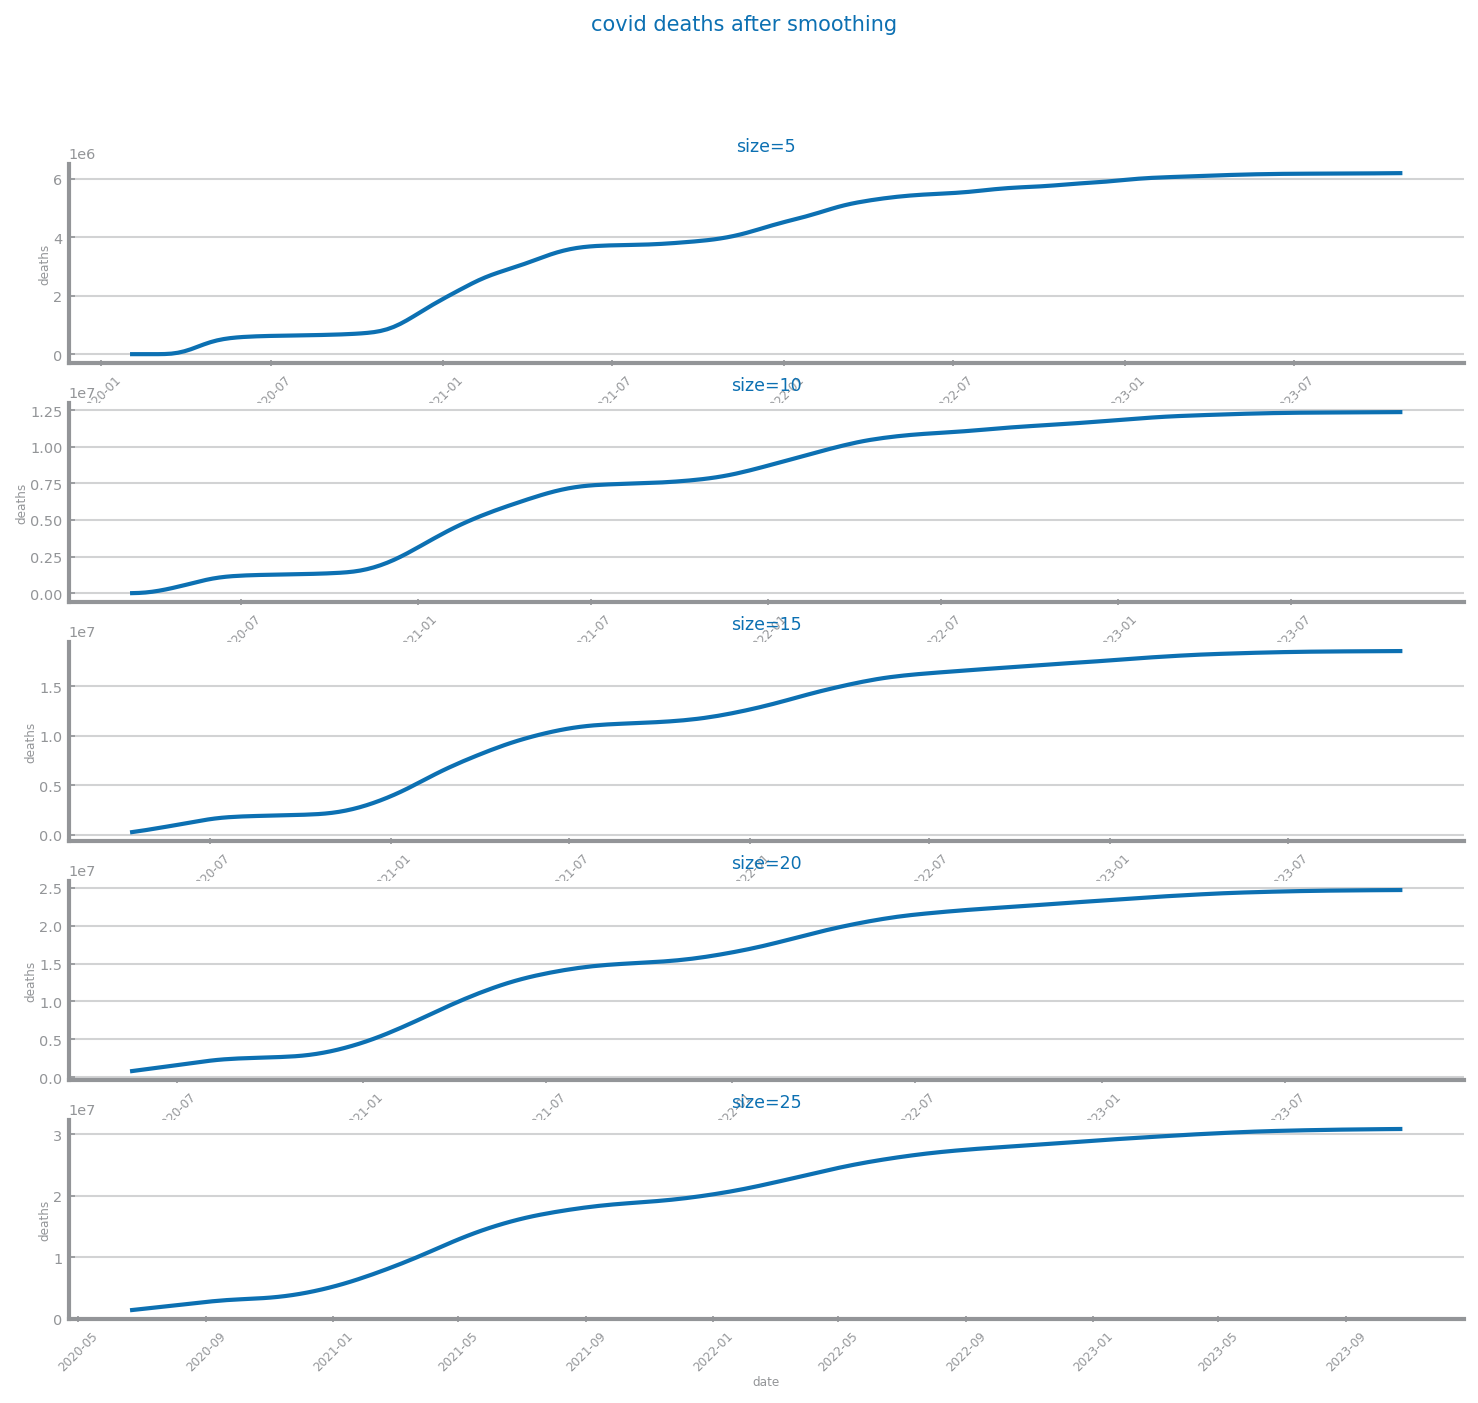

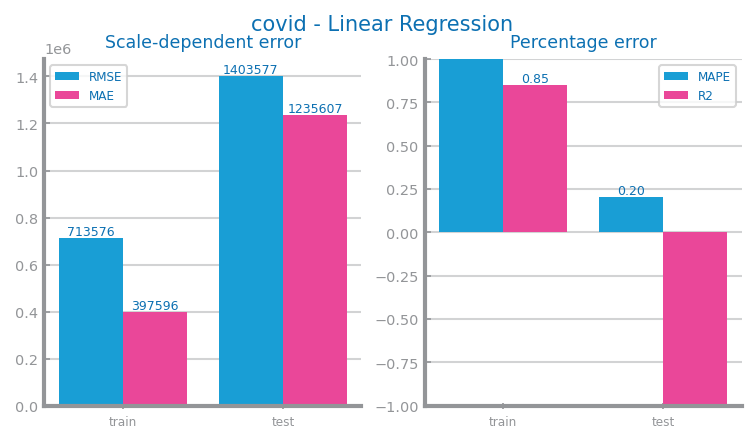

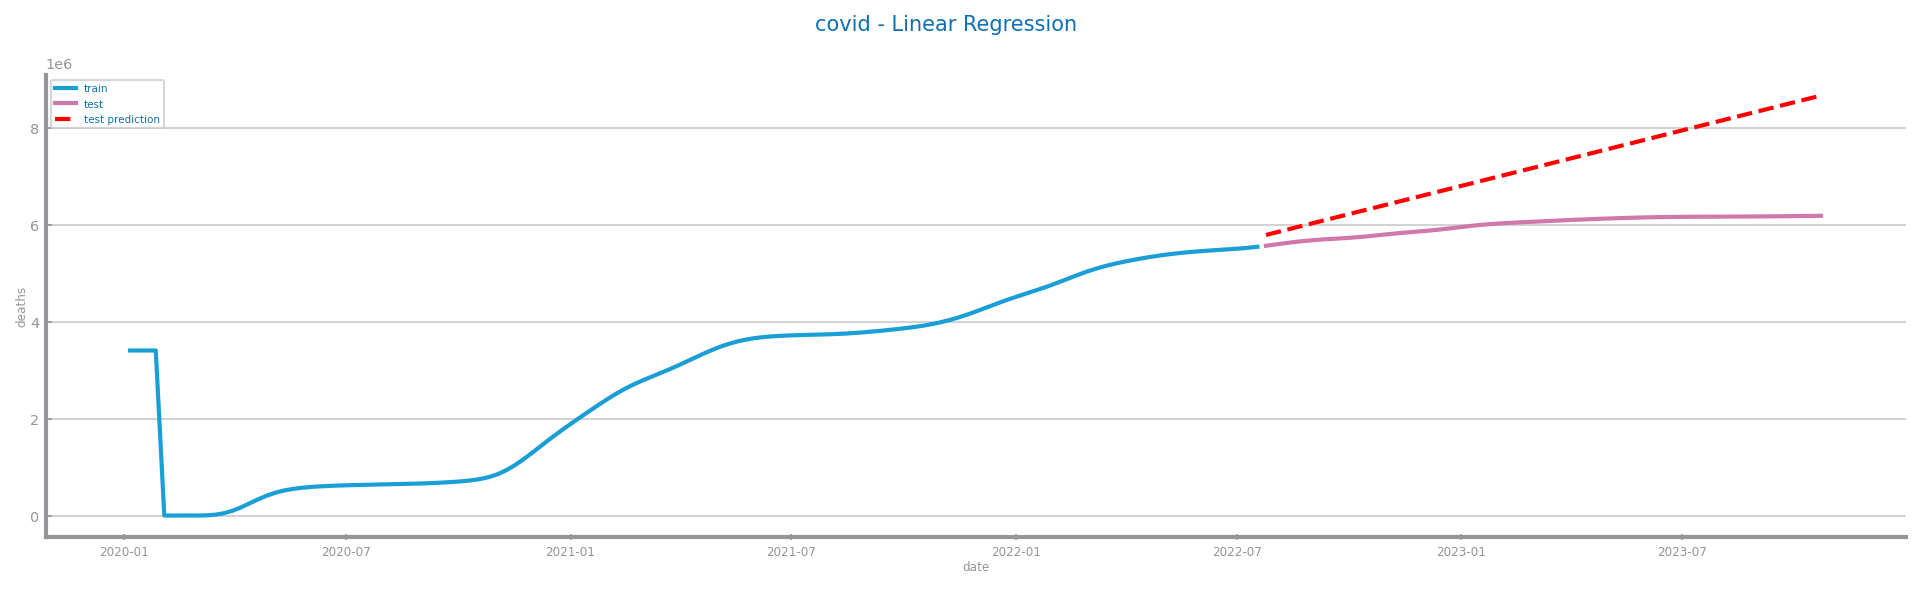

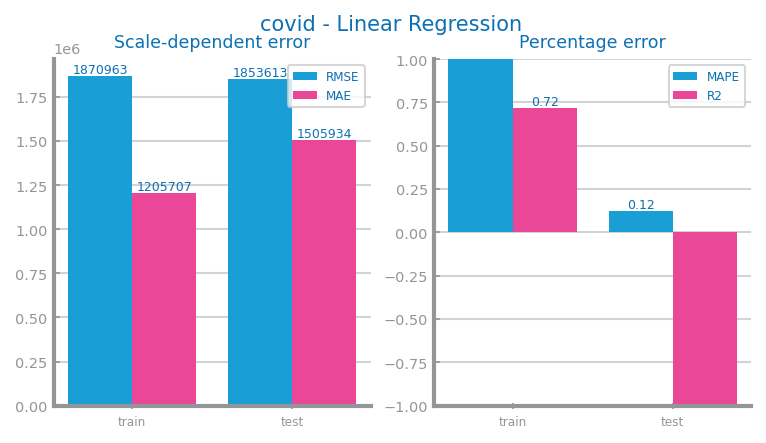

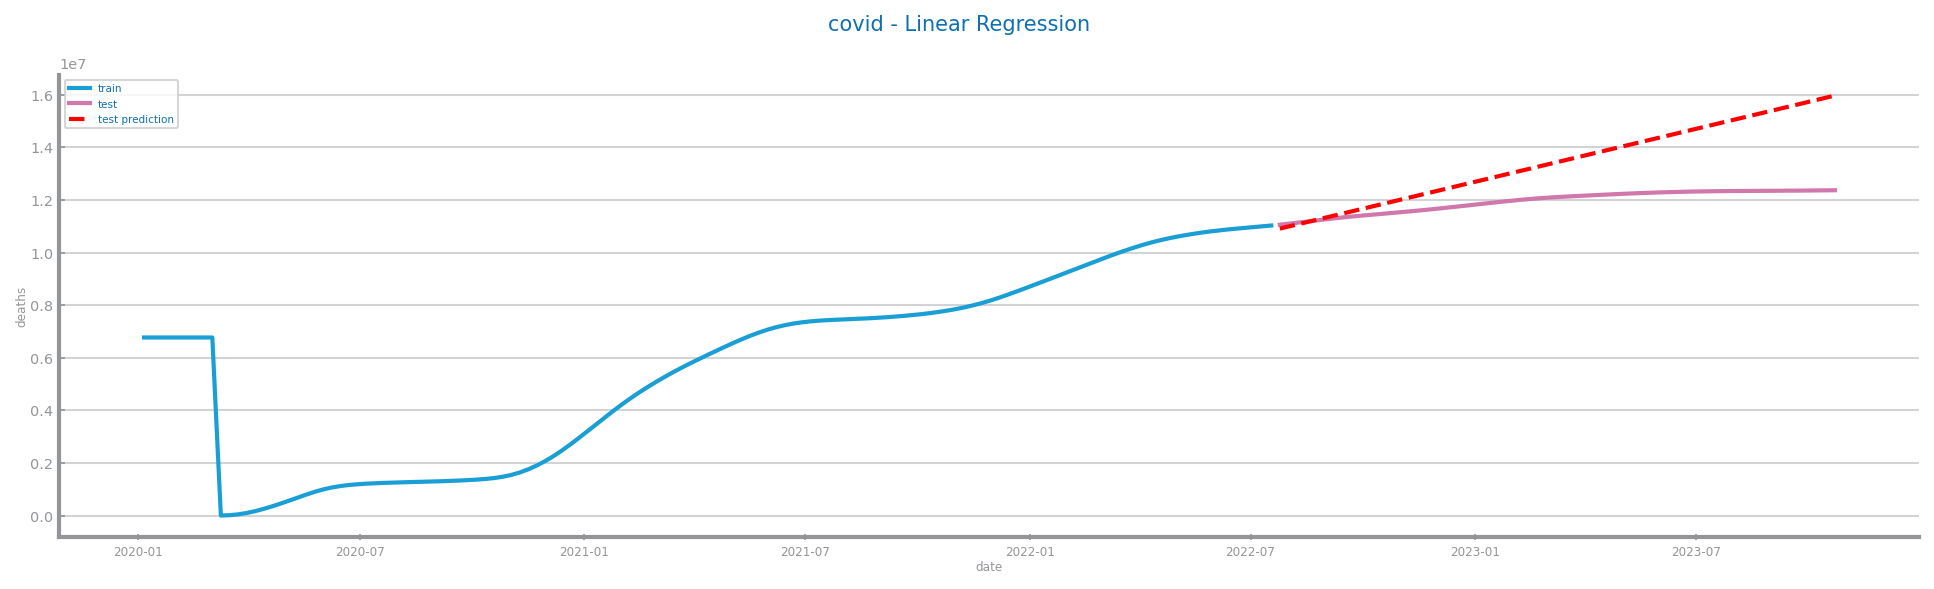

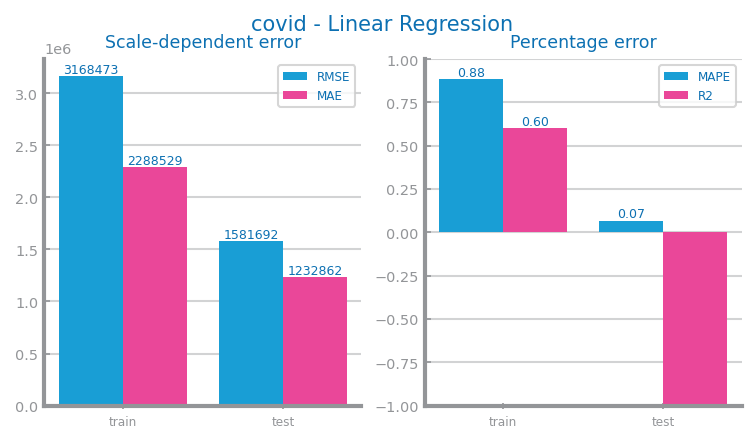

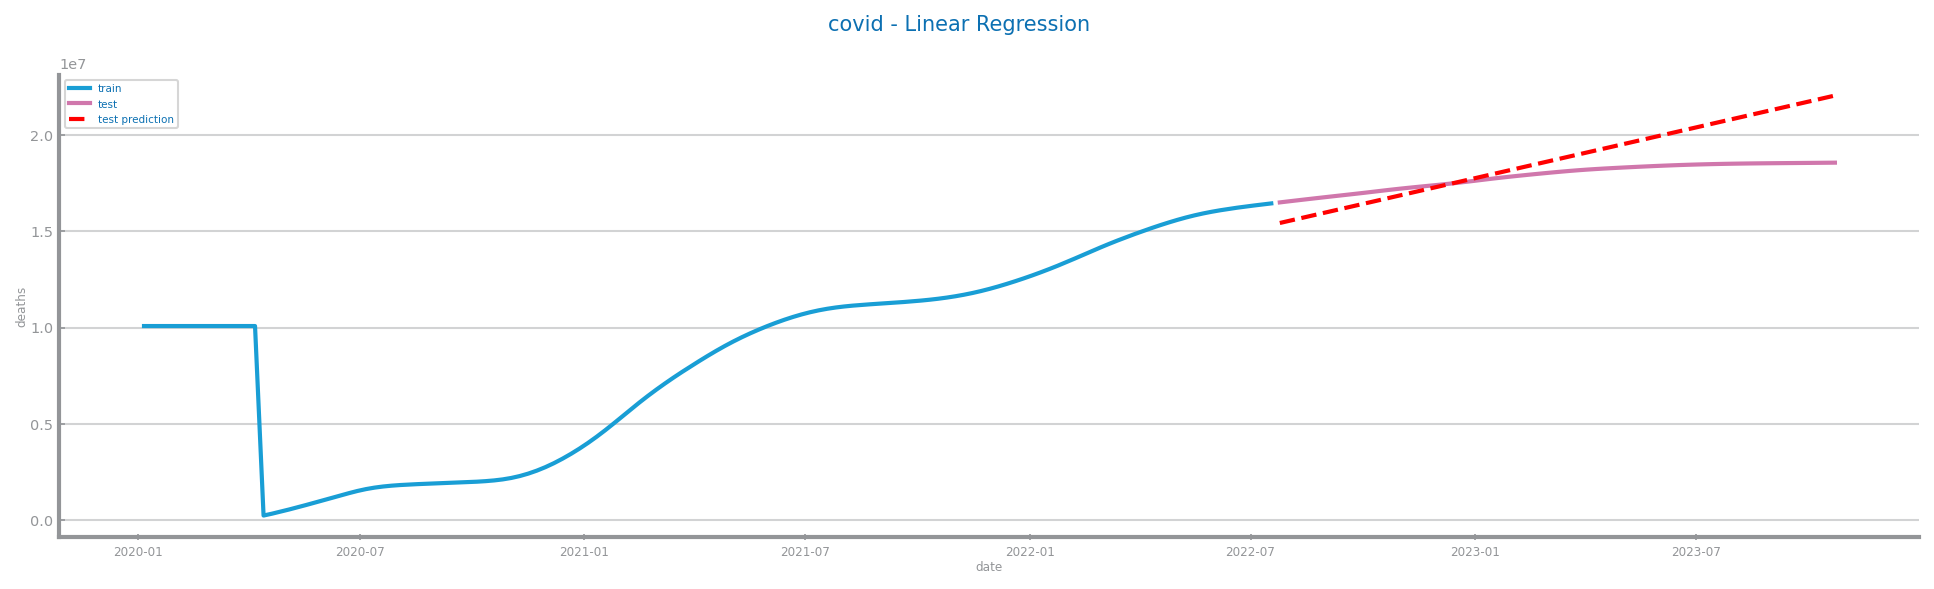

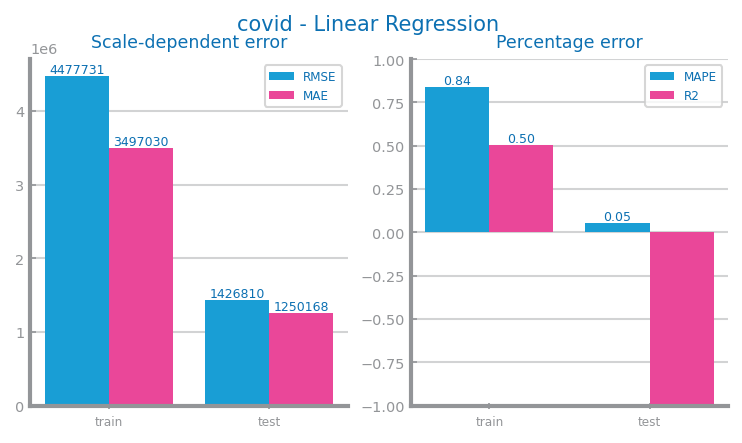

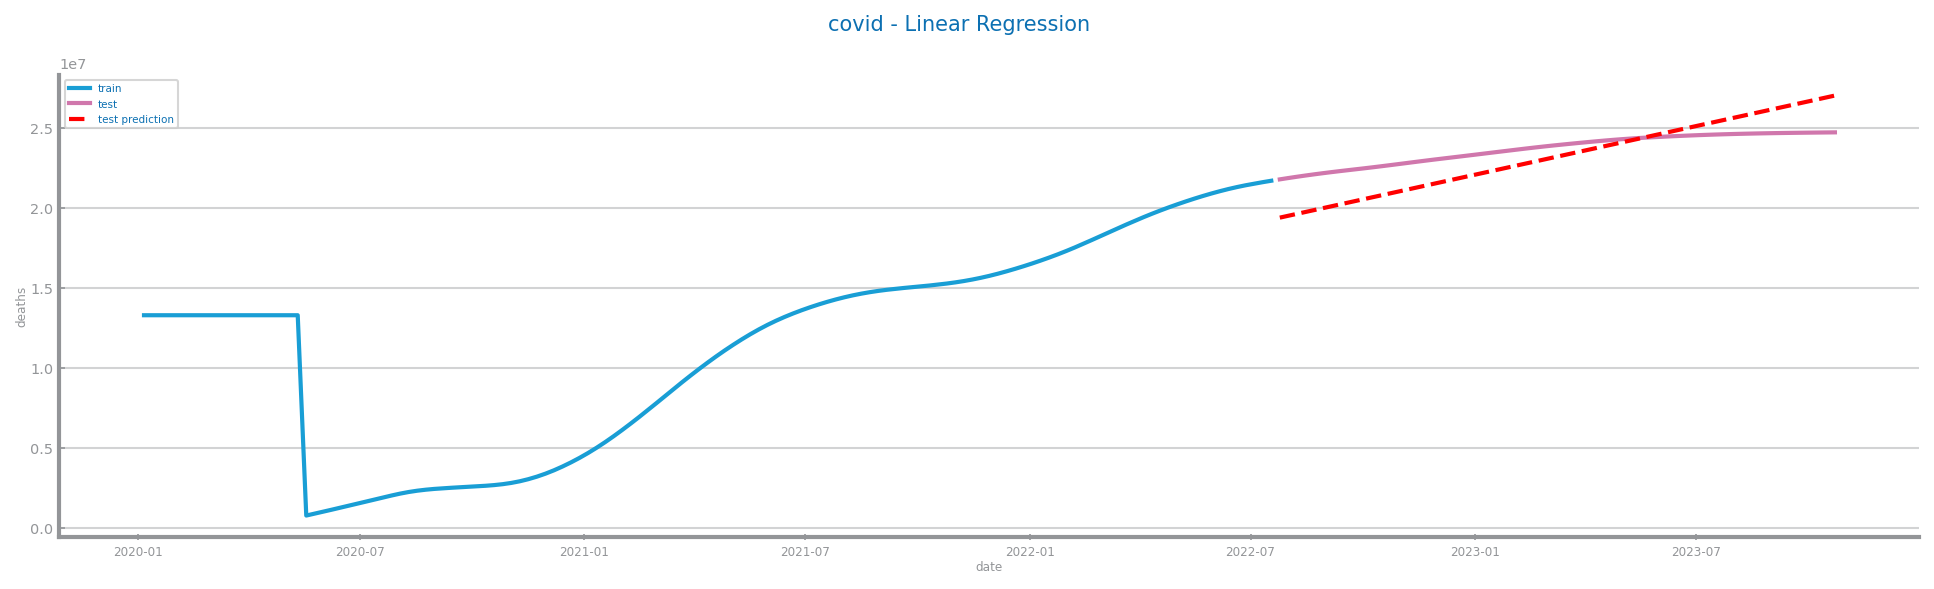

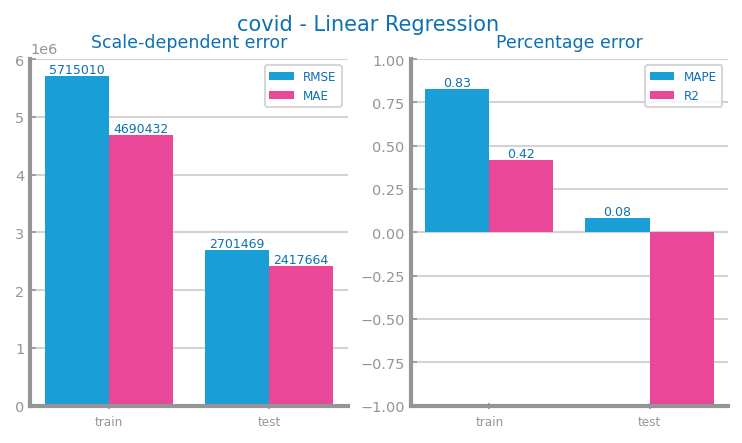

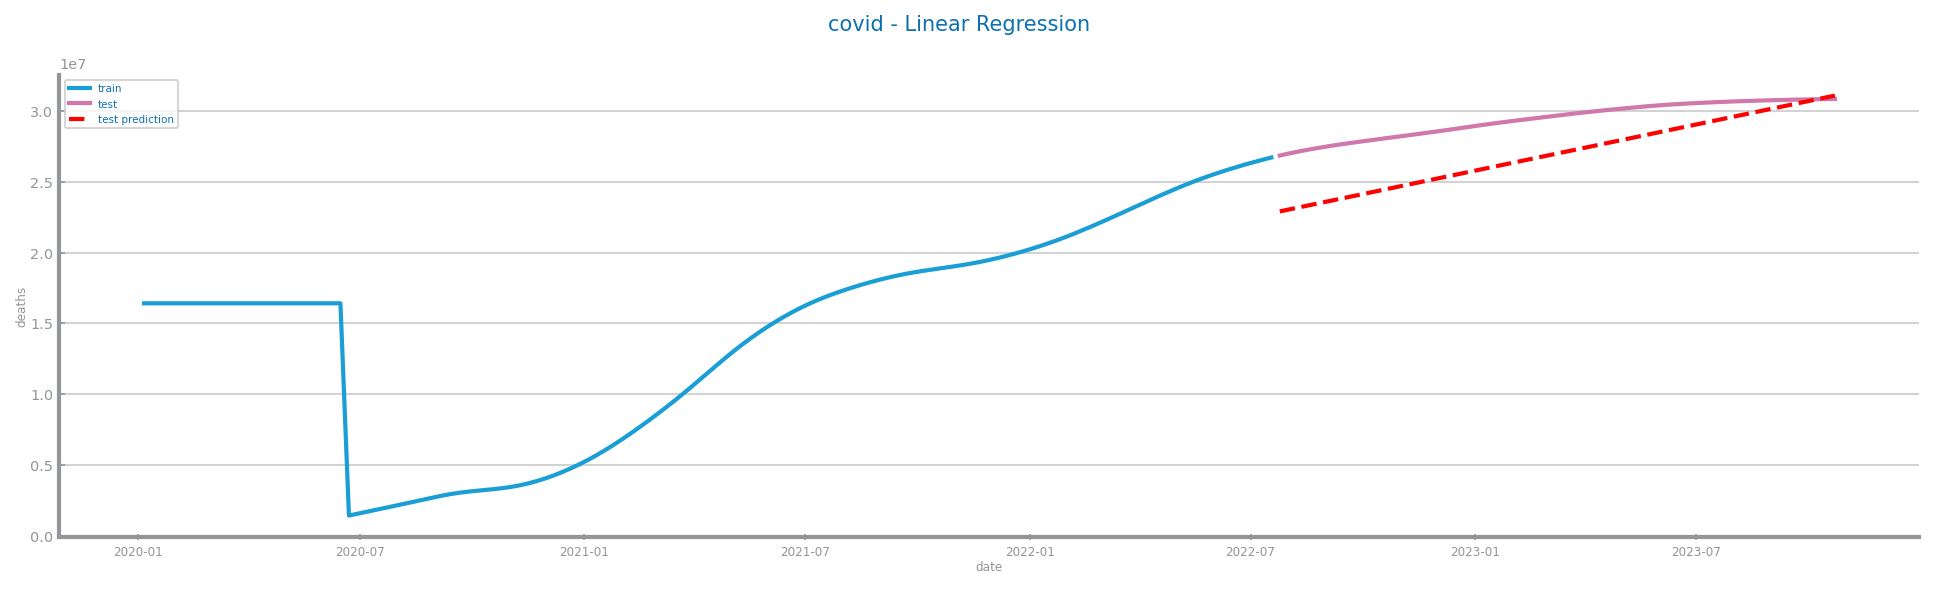

In [19]:
from matplotlib.pyplot import subplots
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from dslabs_functions import dataframe_temporal_train_test_split

sizes: list[int] = [5, 10, 15, 20, 25]
fig: Figure
axs: list[Axes]
fig, axs = subplots(len(sizes), 1, figsize=(3 * HEIGHT, HEIGHT / 2 * len(sizes)))
fig.suptitle(f"{file_tag} {target} after smoothing")

for i in range(len(sizes)):
    ss_smooth: Series = series.rolling(window=sizes[i]).sum()
    plot_line_chart(
        ss_smooth.index.to_list(),
        ss_smooth.to_list(),
        ax=axs[i],
        xlabel=ss_smooth.index.name,
        ylabel=target,
        title=f"size={sizes[i]}",
    )

    train, test = dataframe_temporal_train_test_split(ss_smooth, trn_pct=0.67)

    # MAYBE USE OTHER METHOD TO FILL NAN
    if train.isnull().any() or test.isnull().any():
        train = train.fillna(train.median())
        test = test.fillna(test.median())

    trnX = arange(len(train)).reshape(-1, 1)
    trnY = train.to_numpy()
    tstX = arange(len(train), len(ss_smooth)).reshape(-1, 1)
    tstY = test.to_numpy()

    model = LinearRegression()
    model.fit(trnX, trnY)

    prd_trn: Series = Series(model.predict(trnX), index=train.index)
    prd_tst: Series = Series(model.predict(tstX), index=test.index)

    plot_forecasting_eval(
        train, 
        test, 
        prd_trn, 
        prd_tst, 
        title=f"{file_tag} - Linear Regression"
    )
    savefig(f"images/{file_tag}/smoothing/{sizes[i]}_linear_regression_eval.png")

    plot_forecasting_series(
        train,
        test,
        prd_tst,
        title=f"{file_tag} - Linear Regression",
        xlabel=timecol,
        ylabel=target,
    )
    savefig(f"images/{file_tag}/smoothing/{sizes[i]}_linear_regression_forecast.png")
show()

### we conclude that 20 is the best window size

In [20]:
WIN_SIZE = 20
ss_smooth: Series = series.rolling(window=WIN_SIZE).sum()
ss_smooth.to_csv(f"data/{file_tag}/smoothing/smooth.csv")

# DIFFERENTIATION

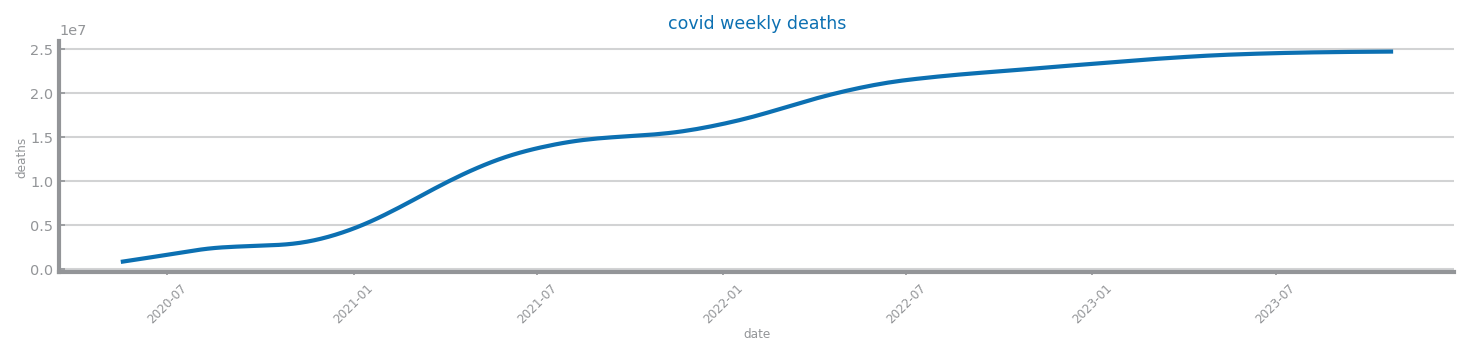

In [21]:
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_line_chart, HEIGHT

filename: str = f"data/{file_tag}/smoothing/smooth.csv"
data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
series: Series = data[target]

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} weekly {target}",
)
show()

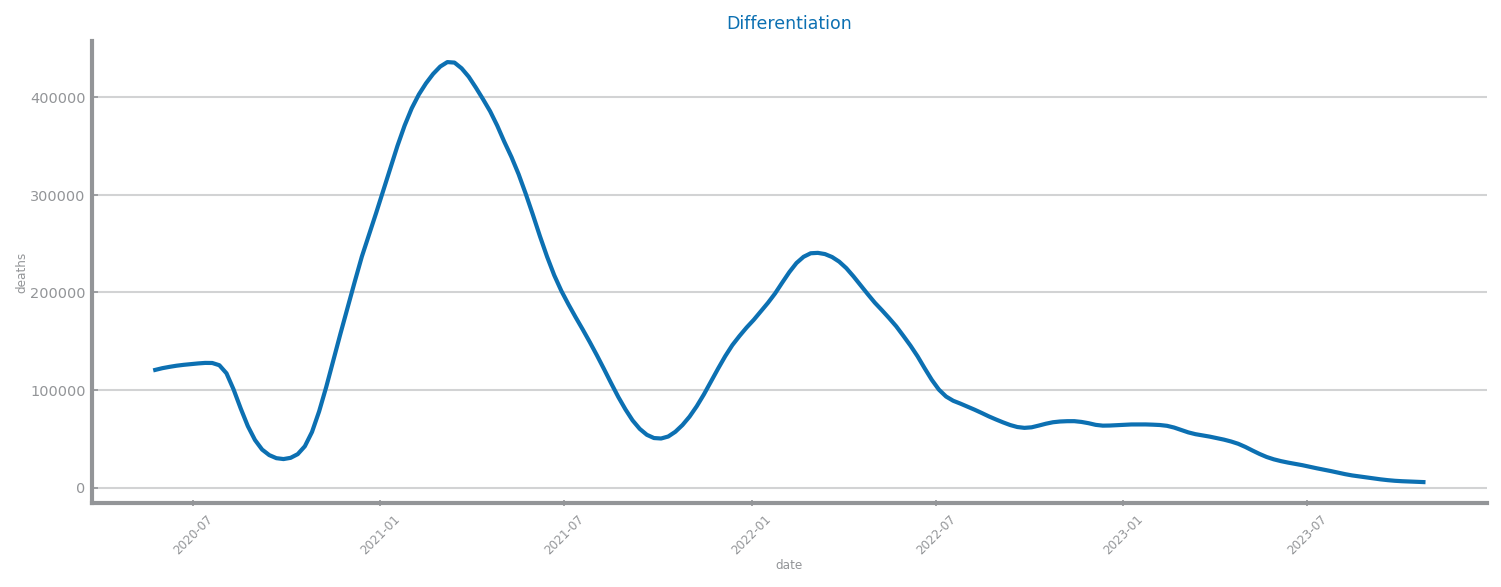

In [22]:
from dslabs_functions import plot_line_chart

ss_diff: Series = series.diff()
figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    ss_diff.index.to_list(),
    ss_diff.to_list(),
    title="Differentiation",
    xlabel=series.index.name,
    ylabel=target,
)
show()

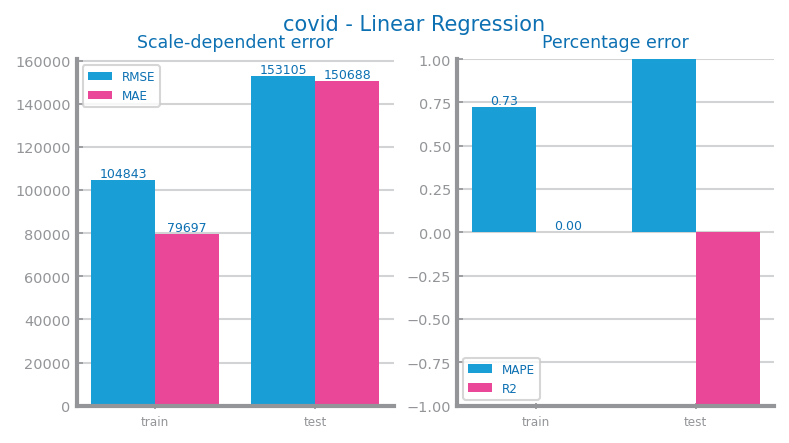

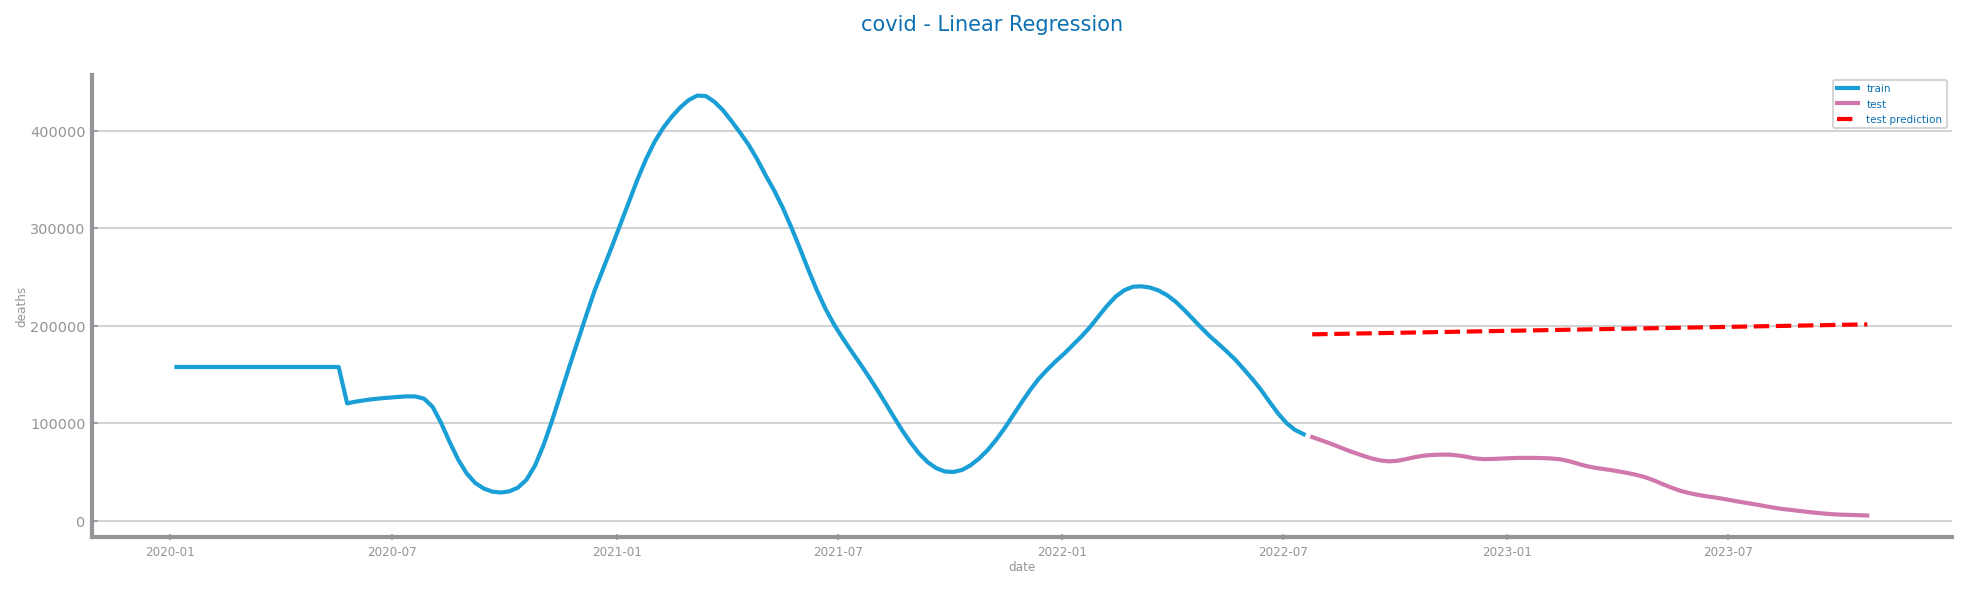

In [23]:
from dslabs_functions import dataframe_temporal_train_test_split
#USER OTHER FUNCTION INSTEAD OF SAVING CSV

train, test = dataframe_temporal_train_test_split(ss_diff, trn_pct=0.67)

# MAYBE USE OTHER METHOD TO FILL NAN
if train.isnull().any() or test.isnull().any():
    train = train.fillna(train.median())
    test = test.fillna(test.median())

trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(ss_diff)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression")
savefig(f"images/{file_tag}/differentiation/first_diff_linear_regression_eval.png")

plot_forecasting_series(
        train,
        test,
        prd_tst,
        title=f"{file_tag} - Linear Regression",
        xlabel=timecol,
        ylabel=target,
    )
savefig(f"images/{file_tag}/differentiation/first_diff_linear_regression_forecast.png")

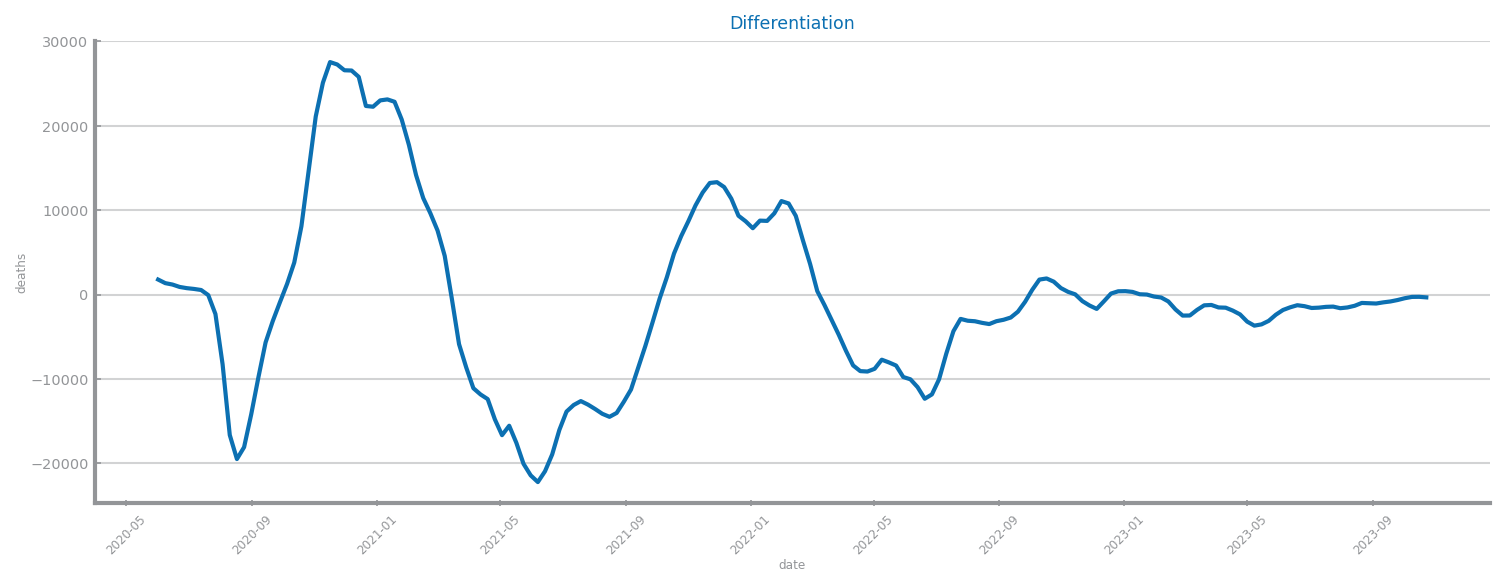

In [24]:
from dslabs_functions import plot_line_chart

ss_diff: Series = ss_diff.diff()
figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    ss_diff.index.to_list(),
    ss_diff.to_list(),
    title="Differentiation",
    xlabel=series.index.name,
    ylabel=target,
)
show()

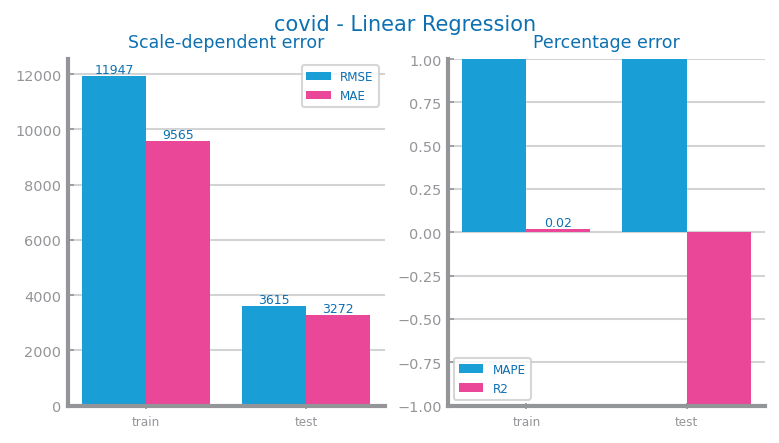

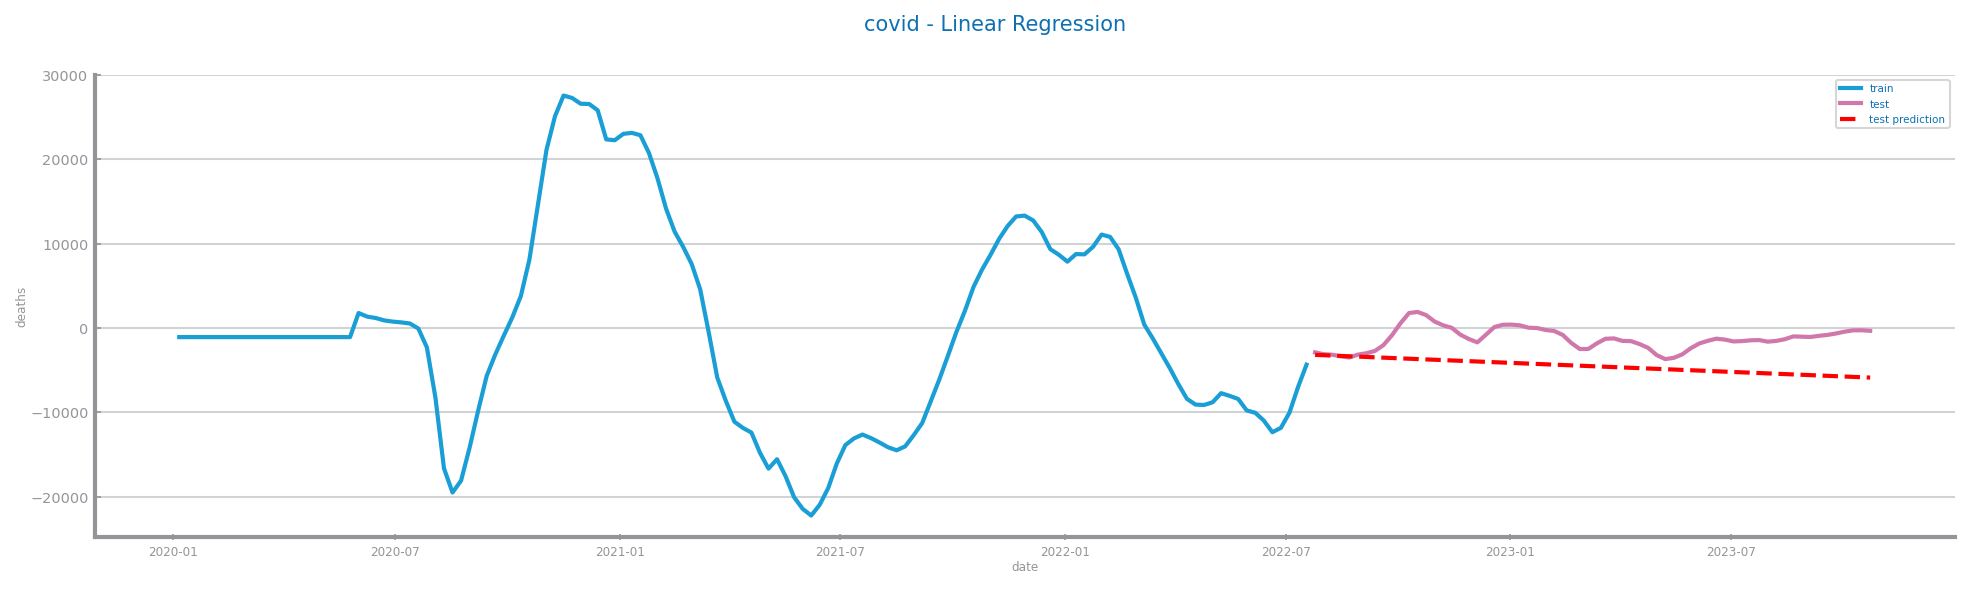

In [25]:
train, test = dataframe_temporal_train_test_split(ss_diff, trn_pct=0.67)

# MAYBE USE OTHER METHOD TO FILL NAN
if train.isnull().any() or test.isnull().any():
    train = train.fillna(train.median())
    test = test.fillna(test.median())

trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(ss_diff)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression")
savefig(f"images/{file_tag}/differentiation/second_diff_linear_regression_eval.png")

plot_forecasting_series(
        train,
        test,
        prd_tst,
        title=f"{file_tag} - Linear Regression",
        xlabel=timecol,
        ylabel=target,
    )
savefig(f"images/{file_tag}/differentiation/second_diff_linear_regression_forecast.png")

### we conclude that second derivative is better

In [26]:
ss_diff.to_csv(f"data/{file_tag}/differentiation/{file_tag}_final.csv")